# Table of contents
1. [Plot 2D data](#plot_2D)
2. [Cut the 30mK data ](#cut_30mk)
3. [Plot cut 450mk ](#plot_cut_450mk)
4. [Plot 3D](#plot_3D)


In [1]:
'''
If you want to use Matplotlib’s interactive plotting with Mayavi’s mlab in IPython you should:

%gui=qt
import matplotlib
matplotlib.use('Qt4Agg')
matplotlib.interactive(True)
'''
#######read hdf E2 File######
import h5py
import numpy as np
#from mayavi import mlab
import matplotlib.pyplot as plt
#from __future__ import print_function
import os.path
from smoothn import smoothn

from scipy.optimize import curve_fit

#import scipy as sp
from scipy import ndimage
from smoothn import smoothn # use spline for smoothing: not good for Bragg peaks (minus values)

import peakutils

import matplotlib as mpl
mpl.style.use('classic')
% matplotlib notebook
#mlab.options.backend = 'envisage' # enable the full  UI of Mayavi

# Plot 2D data <a id='plot_2D'></a>

In [2]:
def loadE2(fpath, fname):
    filedir = os.path.join(fpath,fname); print(filedir)
    hf=h5py.File(filedir,'r')    
    # show the keys in the file
    ks = hf.keys()
    print(ks)
    for index,key in enumerate(ks[:5]):  
        print(index, key, np.shape(hf[key][0:]))
    x, y, z, data, error = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Axes2'][0:], hf[u'Data'][0:], hf[u'Sigma'][0:]
    return x, y, z, data 

class E2_data(object):
    x = 0; y = 0; z = 0
    I = 0; e = 0
    I2d = 0; e2d = 0
    # The class "constructor" - It's actually an initializer 
    def __init__(self, x,y,z,I,e,I2d,e2d):
        self.x = x
        self.y = y
        self.z = z
        self.I = I
        self.e = e
        self.I2d = I2d
        self.e2d = e2d
        
class E2_data_1d(object):
    x = 0; I = 0; e = 0
    def __init__(self, x,I,e):
        self.x = x
        self.I = I
        self.e = e
        
class E2_data_2d(object):
    x = 0; y = 0; I = 0; e = 0
    def __init__(self, x,y,I,e):
        self.x = x
        self.y = y
        self.I = I
        self.e = e

def loadE2_obj0(fpath, fname, infro=0):# set empty pixls to nan for mean
    filedir = os.path.join(fpath,fname); print(filedir)
    hf=h5py.File(filedir,'r')    
    # show the keys in the file
    ks = hf.keys()
    if infro:
        for index,key in enumerate(ks[:5]):  
            print(index, key, np.shape(hf[key][0:]))
            
    x, y, z, data, error = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Axes2'][0:], hf[u'Data'][0:], hf[u'Sigma'][0:]
    #data = np.ma.masked_where(data==0,data)# mask Nan values then plot in white color
    #error = np.ma.masked_where(error==0,error)
    data = np.where(data==0,np.nan, data)
    error = np.where(error==1,np.nan, error)
    return E2_data(x,y,z,data,error,
                   np.nanmean(data,axis=0), np.nanmean(error,axis=0)) #np.nanmean(error**2,axis=0)**0.5) 

def loadE2_obj(fpath, fname, infro=0):
    filedir = os.path.join(fpath,fname); print(filedir)
    hf=h5py.File(filedir,'r')    
    # show the keys in the file
    ks = hf.keys()
    if infro:
        for index,key in enumerate(ks[:5]):  
            print(index, key, np.shape(hf[key][0:]))            
    x, y, z, data, error = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Axes2'][0:], hf[u'Data'][0:], hf[u'Sigma'][0:]
    #data = np.ma.masked_where(data==0,data)#mask Nan values then plot in white color
    #error = np.ma.masked_where(error==0,error)
    return E2_data(x,y,z,data,error,
                   np.mean(data,axis=0),np.mean(error**2,axis=0)**0.5) 

def cut2d(e2_obj, ool, hho, intax):# ool is row (ax=0), hho is col(ax=1)
    mask0 = (e2_obj.x>=hho[0])&(e2_obj.x<=hho[1])
    mask1 = (e2_obj.y>=ool[0])&(e2_obj.y<=ool[1])

    cut = np.ix_(mask1, mask0)# ool is row, hho is col
    I2d, e2d = e2_obj.I2d[cut], e2_obj.e2d[cut]
    I1d, e1d = np.nanmean(I2d, axis=intax), np.nanmean(e2d,axis=intax) #((e2d**2).mean(axis=intax))**0.5
    
    #I2d = np.ma.masked_where(I2d==0,I2d)
    if intax==1: # integrate the (hho) axis
        ax = e2_obj.y[(e2_obj.y>=ool[0])&(e2_obj.y<=ool[1])]
    elif intax==0: # integrate the (ool) axis
        ax = e2_obj.x[(e2_obj.x>=hho[0])&(e2_obj.x<=hho[1])]
    return E2_data_1d(ax, I1d, e1d)

def cut3d(e2_obj, h_ho, ool, hho, intaxs):# h_ho is page(ax=0), ool is row (ax=1), hho is col(ax=2), intaxs (list) is axes to integrate over
    mask2 = (e2_obj.x>=hho[0])&(e2_obj.x<=hho[1])
    mask1 = (e2_obj.y>=ool[0])&(e2_obj.y<=ool[1])
    mask0 = (e2_obj.z>=h_ho[0])&(e2_obj.z<=h_ho[1])
    
    cut = np.ix_(mask0, mask1, mask2)
    I3d, e3d = e2_obj.I[cut], e2_obj.e[cut] 
    Icut, ecut = np.nanmean(I3d, axis=tuple(intaxs)), np.nanmean(e3d, axis=tuple(intaxs)) 
    # nanmean only take tuple to indecate multiple axes!!! (Tuple: (1,) is a tuple; (1) is a int)
    if len(intaxs)==2:# 1D cut
        ax = list(set([0,1,2])-set(intaxs))[0]
        if ax==0:
            axs = e2_obj.z[mask0]
        elif ax==1: 
            axs = e2_obj.y[mask1]
        elif ax==2:
            axs = e2_obj.x[mask2]
        return E2_data_1d(axs, Icut, ecut)
    elif len(intaxs)==1:# 2D slice
        if intaxs[0]==0:
            axs_x = e2_obj.y[mask1]
            axs_y = e2_obj.x[mask2]
        elif intaxs[0]==1: 
            axs_x = e2_obj.z[mask0]
            axs_y = e2_obj.x[mask2]
        elif intaxs[0]==2:
            axs_x = e2_obj.z[mask0]
            axs_y = e2_obj.y[mask1]
        return E2_data_2d(axs_x, axs_y, Icut, ecut)
        
def loadE2_2D(fpath, fname):
    filedir = os.path.join(fpath,fname); print(filedir)
    hf=h5py.File(filedir,'r')    
    # show the keys in the file
    ks = hf.keys()
    for index,key in enumerate(ks[:5]):  
        print(index, key, np.shape(hf[key][0:]))
    x, y, data = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Data'][0:]
    return x, y, data

def binningE2(x, y, z, data, xyzLens, xyzBins):# xyzlen and xyzbins are 1by3 lists
    '''Binning the 3D data'''
    #bin size
    xlen=500;xbin=5
    ylen=500;ybin=5
    zlen=10; zbin=2  
    xlen, ylen, zlen = xyzLens
    xbin, ybin, zbin = xyzBins    
    #bining
    x=x.reshape(xlen/xbin,xbin).mean(axis=1)
    y=y.reshape(ylen/ybin,ybin).mean(axis=1)
    z=z.reshape(zlen/zbin,zbin).mean(axis=1)
    print("raw data",np.shape(data))
    data=data.transpose((2,1,0)).reshape(xlen/xbin,xbin,ylen/ybin,ybin,zlen/zbin,zbin).mean(axis=5).mean(axis=3).mean(axis=1)
    print("binned data",data.shape)
    return x, y, z, data

def myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,opacity):
    '''Plot the 3D data with Mayavi'''
    x, y, z = np.meshgrid(x1,y1,z1, indexing='ij')
    AXrange = [x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),z1.max()]
    #Extent  = np.array([x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),(z1.max()+Zextent)])
    %gui qt
    mfig = mlab.figure(bgcolor=(1,1,1), fgcolor=(0.,0.,0.))
    grid = mlab.pipeline.scalar_field(x,y,z,data_view)#grid.spacing=[1.0, 1.0, 2]
    #extend: shape of the volume but the axis lable changes also. Axes range could change the lable back.
    isos = mlab.pipeline.iso_surface(grid,opacity=opacity,transparent=True,
                              vmin=vmin,vmax=vmax,contours=contours,extent=extent)

    mlab.outline()
    ax = mlab.axes(xlabel=r"(H,H,0)",ylabel="(0,0,L)",zlabel="(K,-K,0)",nb_labels=5,ranges=AXrange)#,y_axis_visibility = False)
    ax.axes.font_factor = 2
    ax.axes.label_format = '%1.1f'
    ax.label_text_property.bold = False
    ax.label_text_property.italic = False
    ax.label_text_property.color = (.0, .0, .0)
    ax.property.color = (1.0, 1.0, 1.0) 

    #mlab.colorbar(orientation='vertical')
    cb = mlab.colorbar(orientation='horizontal',nb_labels=5, label_fmt='%1.4f')
    cb.scalar_bar_representation.position = [0.1, 0.85] # position
    cb.scalar_bar_representation.position2 = [0.8, 0.08] # lenght and width
    return mfig, ax

def sum_plot2D(x, y, data,smooth,vmin,vmax,axlim):
#def sum_plot2D(x, y, data,smooth,vmin,vmax,axlim,sigma_y, sigma_x):
    '''Sum the 3D data to [HHL] plane, and smooth, plot with Pcolor() Matplotlib'''
    data = np.mean(data, axis=0)
    from smoothn import smoothn
    print(data.shape,smooth)
    Z,s,exitflag,Wtot = smoothn(data,s=smooth) 
        
    Zm = np.ma.masked_where(data==0,Z)# mask Nan values then plot in white color
        
    fig = plt.figure(); #plt.gca().set_aspect(aspect)
    pcol = plt.pcolormesh(x, y, Zm, cmap='jet',linewidth=0,rasterized=True,vmin=vmin, vmax=vmax)
    pcol.set_edgecolor('face') # remove the white lines in the plot
    plt.grid()
    
    plt.axis(axlim)
    plt.xlabel('(HH0)',size=14)
    plt.ylabel('(00K)',size=14)
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

    cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
    cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
    cb.ax.tick_params(labelsize=12)
    #plt.show()
    return fig, plt.gca(), cb

from lmfit.lineshapes import pvoigt # pvoigt(x, amplitude=1.0, center=0.0, sigma=1.0, fraction=0.5)
def wrapper_fit_func_PV(x,N,*args):# multi-Gaussion: varibale nb of gaussion functions
    y = 0.0
    for i in xrange(N):
        y = y + pvoigt(x,*args[0][i*4:(i+1)*4])
    return y

# Ｆｏｒ　ｃｈａｎｇｉｎｇ　ｔｈｅ　ｃｏｌｏｒｂａｒ
#cb.remove()# remove the old cb because it is to long; and modify it also diffecult
#cb = plt.colorbar(fraction=0.05, pad=0.04, shrink=1,aspect=20)
#bbox = ax2.get_position() cax = fig.add_axes([bbox.xmax*1.03, bbox.ymin, bbox.width*0.08, bbox.height]) fig.colorbar(quadmesh,cax=cax)
#cb = fig.colorbar(quadmesh,ax=ax, shrink=.5, pad=.2, aspect=10)
# cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02]) fig.colorbar(thplot, cax=cbar_ax, orientation="horizontal")
#matplotlib.colorbar.make_axes(ax,location=None, orientation=None, fraction=0.05, shrink=0.9, aspect=20)

In [3]:
# Load the unsubtracted data to get the error
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = [r'30mk_0p25T_one30-e210913.hdf',
         r'30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf',
         r'30mK_1p25T_sub_20k.hdf',
         r'30mk_1p5T_one30_sub_20k_0T_5h5h10.hdf',
         r'30mk_1p75T_one30_sub_20k_0T.hdf']

print(10.61/2**0.5)

7.50240294839


In [4]:
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = r'30mK_1p25T_sub_20k.hdf'
fname = r'30mK_0p25T_one30_sub_20k.hdf'
fname = '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf'
fname = '30mk_2T_one90-sub_20k_0T_5h5h10.hdf'
fname = '30mK_1T_two180-e210910-911-915.hdf'
#x, y, z, data  = loadE2(fpath,fname)
#xyzLens, xyzBins = [500,500,10], [5,5,2]
#x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)

#t50b1t=loadE2_obj(fpath,fname,infro=1)
#print(t50b1t.e[5,300,:])

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
('raw data', (10L, 500L, 500L))
('binned data', (100L, 100L, 5L))
((500L, 500L), 1)


<IPython.core.display.Javascript object>


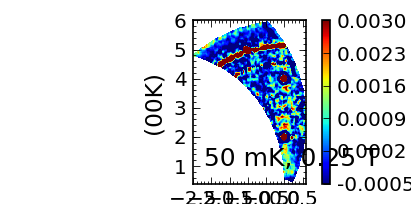

In [5]:
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = r'30mK_0p25T_one30_sub_20k.hdf'
x, y, z, data  = loadE2(fpath,fname)

# Plot 3D with Mayavi
xyzLens, xyzBins = [500,500,10], [5,5,2]
x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
extent = np.array([x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),(z1.max()+3)])
vmin,vmax = -0.0005,0.003
#mfig,ax = myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,0.5)
#mlab.savefig(os.path.join(fpath,fname.replace('.hdf','.png')), size=None, figure=mfig, magnification='auto')

# Plot 2D with matplotlib
smooth = 1
axlim = [-2.5,0.6,0.4,6]
fig, ax, cb = sum_plot2D(x, y, data,smooth,vmin,vmax,axlim)
ax.set_aspect(0.8)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-2.2,1,'50 mK, 0.25 T', fontsize=15)
plt.grid('off')
cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
cb.ax.set_yticklabels(['{:.4f}'.format(i) for i in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')
#fig.savefig(os.path.join(fpath,fname.replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
('raw data', (10L, 500L, 500L))
('binned data', (100L, 100L, 5L))
((500L, 500L), 1)


<IPython.core.display.Javascript object>


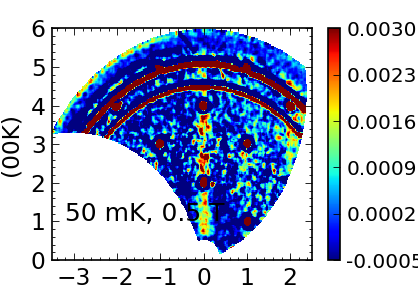

In [30]:
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf'
x, y, z, data  = loadE2(fpath,fname)

# Plot 3D with Mayavi
xyzLens, xyzBins = [500,500,10], [5,5,2]
x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
extent = np.array([x1.min(),x1.max()+5,y1.min(),y1.max(),z1.min(),(z1.max()+4)])
vmin,vmax = -0.0005,0.003
#mfig,ax = myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,0.5)

# Plot 2D with matplotlib
smooth = 1
axlim = [-3.5,2.5,0,6]
fig, ax, cb = sum_plot2D(x, y, data,smooth,vmin,vmax,axlim)
#fig, ax, cb = sum_plot2D(x, y, data,smooth,vmin,vmax,axlim,1,1) # change function definition to use
ax.text(-3.2,1,'50 mK, 0.5 T', fontsize=15)
ax.grid('off')
cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
cb.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')

#fig.savefig(os.path.join(fpath,fname.replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_0T_sub_20k_0T_5h5h10.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


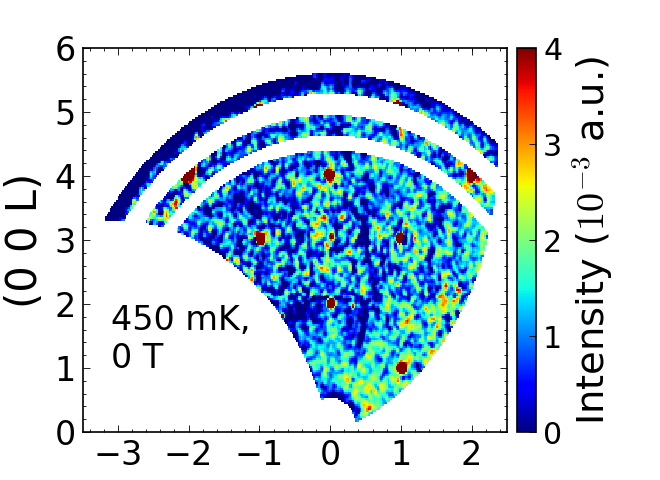

In [48]:
# Remove bad regions of 1T data according to 0.5T data
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/' 
fname = ['30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf',
         '450mk_0p5T_one90_sub_20k_0T_5h5h_2D.hdf',
         '30mK_1T_two180-sub_20k_0T_5h5h10.hdf',
         '450mk_2T_sub_20k_0T_5h5h10.hdf',
         '450mk_0T_sub_20k_0T_5h5h10.hdf',
         '30mK_0T_sub_20k.hdf']

# Load the 50mK 0.5T 90deg data to plot and mask the other two files
x, y, z, data  = loadE2(fpath,fname[0])
# Nanmean along the out-of-palne direction
#x1, y1, z1 = np.meshgrid(z,x,y, indexing='ij')
#rad = np.sqrt(2*x1**2 + y1**2 + 2*z1**2)

#Z,s,exitflag,Wtot = smoothn(data,s=1) 
Z = ndimage.filters.gaussian_filter(data, [1,1,1], mode='constant')
Z[data==0] = np.nan
Z = np.nanmean(Z, axis=0)

# Mask the data of powder ring
x1, y1= np.meshgrid(x,y, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2 )
Z[(rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.8)] = np.nan # for 30mK
Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color

#################
#################
which =4 # 0: comment both "450mK-0.5T" and "50mK-1T and 450mK-2T data" ; 
         # 1: comment "50mK-1T and 450mK-2T data"
         # 2, 3, 4 and 5: comment "450mK-0.5T"
texts = ['50 mK,\n0.5 T', '450 mK,\n0.5 T','50 mK,\n1.0 T', '450 mK,\n2.0 T', '450 mK,\n0 T', '50 mK,\n0 T']
vmins = [0.000, -0.0001, 0.000, 0.001, 0.000, 0.000]# the  background is increasing compared with 20K data, which will be subtracted
vmaxs = [0.004, 0.0019, 0.006,  0.004, 0.004, 0.004]
cbticks = [5, 3, 4, 4, 5, 5]

# which=1, 450mK-0.5T only: 2D file (comment it for plotting above data)
### Comment it for ploting the other data
# x, y, data  = loadE2_2D(fpath,fname[which])
# Z = ndimage.filters.gaussian_filter(data, [1.2,1.2], mode='constant')# Z,s,exitflag,Wtot = smoothn(data,s=1)
# Z[data==0] = np.nan
# Z[(rad>4.4)&(rad<4.65)|(rad>4.95)&(rad<5.3)|(rad>5.6)] = np.nan
#Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color
###

# which=2, 3, 4 and 5 with 50mK-1T, 450mK-2T, 450mK-0T  and 30mK-0T data (180deg): masked based on the 30mK data for removing the bad 2nd 90deg scan
### Comment it for plotting the data above
x, y, z, data1  = loadE2(fpath,fname[which])
Z1 = ndimage.filters.gaussian_filter(data1, [1.,1,1], mode='constant') # Z1,s1,exitflag1,Wtot1 = smoothn(data1,s=1.) 
Z1[data1==0] = np.nan
Z1 = np.nanmean(Z1, axis=0)
Z[(rad>4.4)&(rad<4.65)|(rad>4.95)&(rad<5.3)|(rad>5.6)] = np.nan # mask based on the  90deg data 
Zm = np.ma.masked_where(np.isnan(Z),Z1)# mask Nan values then plot in white color
###

# Plot
fig = plt.figure(figsize=(5.5,4)); #plt.gca().set_aspect(aspect)
#vmin,vmax = -0.0005,0.004
pcol = plt.pcolormesh(x, y, (Zm-vmins[which])*1000, cmap='jet',linewidth=0,rasterized=True,vmin=0, vmax=(vmaxs[which]-vmins[which])*1000)
pcol.set_edgecolor('face') # remove the white lines in the plot
plt.text(-3.1,1.,texts[which], fontsize=20)
plt.grid('off')

plt.axis([-3.5,2.5,0,6])
#plt.axes().set_aspect(0.717)
plt.xlabel('(H -H 0)',size=25)
plt.ylabel('(0 0 L)',size=25)
plt.minorticks_on()
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(which='both', direction='in')

cb = plt.colorbar(ticks=np.linspace(0,(vmaxs[which]-vmins[which])*1000,num=cbticks[which],endpoint=True),pad=0.02)  # plt.colorbar(format='%.0e')
cb.ax.set_ylabel('Intensity ($10^{-3}$ a.u.)',fontsize=23)
cb.ax.tick_params(labelsize=18)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-3, 0))
#cb.formatter.set_useOffset(0.001)
cb.draw_all()
plt.tick_params(which='both', direction='in')
cb.ax.tick_params(which='both', direction='in')
fig.savefig(os.path.join(fpath,fname[which].replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


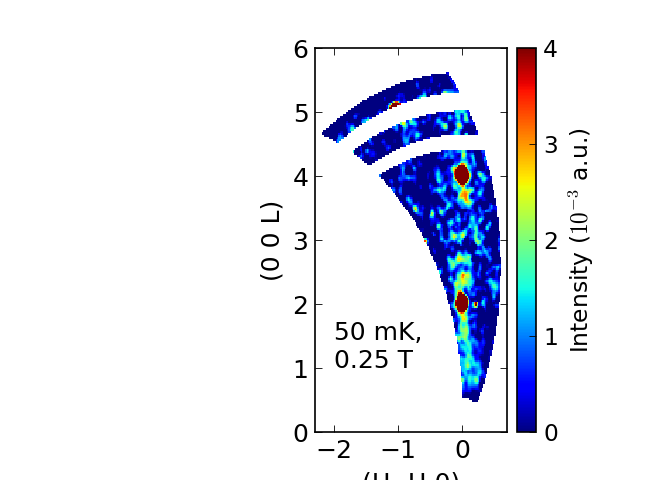

In [12]:
# Plot some data at 30mK
#### reomve powder rings, shift data for bkg corr
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = [r'30mK_0p25T_one30_sub_20k.hdf',
         r'30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf',
         r'30mK_1p25T_sub_20k.hdf',
         r'30mk_1p5T_one30_sub_20k_0T_5h5h10.hdf',
         r'30mk_1p75T_one30_sub_20k_0T.hdf']
texts = ['50 mK,\n0.25 T','50 mK,\n0.75 T', '50 mK,\n1.25 T', '50 mK,\n1.5 T','50 mK,\n1.75 T']
vmins = [0.000, 0.000, 0.002, 0.002, 0.003]# the  background is increasing compared with 20K data, which will be subtracted
vmaxs = [0.004, 0.004, 0.006,0.006,0.007]
#cbticks = [4, 7, 7, 7, 7, 7]
cbticks = [5, 5, 5, 5, 5, 5]

which = 0
x, y, z, data  = loadE2(fpath,fname[which])
#loadE2_2D(fpath,fname)
vmin,vmax =vmins[which], vmaxs[which]

# Plot 3D with Mayavi
# xyzLens, xyzBins = [500,500,10], [5,5,2]
# x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
# contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
# extent = np.array([x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),(z1.max()+4)])
# vmin,vmax =vmins[which], vmaxs[which]
# mfig,ax = myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,0.5)

# Plot 2D with matplotlib
#smooth = 1
#axlim = [-2.5,0.7,0,6]
# fig, ax, cb = sum_plot2D(x, y, Zm, smooth,vmin,vmax,axlim)
# ax.set_aspect(0.8)
# ax.text(-2.2,1.5,texts[which], fontsize=15)
# ax.grid('off')
# cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
# cb.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')
# fig.savefig(os.path.join(fpath,fname[which].replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  

# Plot 2D with matplotlib
Z = ndimage.filters.gaussian_filter(data, [1.,1.2,1.2], mode='constant')# Z,s,exitflag,Wtot = smoothn(data,s=1)
Z[data==0] = np.nan
Z = np.nanmean(Z, axis=0)
x1, y1 = np.meshgrid(x,y, indexing='ij')
rad = np.sqrt(2*x1**2 + y1**2)
Z[(rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.6)] = np.nan # for 30mK
Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color

fig = plt.figure(figsize=(5.5,4)); #plt.gca().set_aspect(aspect)
pcol = plt.pcolormesh(x, y, (Zm-vmins[which])*1000, cmap='jet',linewidth=0,rasterized=True, vmin=0,vmax=(vmaxs[which]-vmins[which])*1000)
pcol.set_edgecolor('face') # remove the white lines in the plot
plt.text(-2.,1.,texts[which], fontsize=15)
plt.grid('off')

plt.axis([-2.3,0.7,0,6])

plt.gca().set_aspect(1/1)
#plt.minorticks_on()
plt.locator_params(axis='y', nbins=7)
plt.locator_params(axis='x', nbins=4)
plt.xlabel('(H -H 0)',size=15)
plt.ylabel('(0 0 L)',size=15)
plt.xticks(color='k', size=15)
plt.yticks(color='k', size=15)
plt.tick_params(which='both', direction='in')

cb.remove()
cb = plt.colorbar(ticks=np.linspace(0,(vmaxs[which]-vmins[which])*1000,num=cbticks[which],endpoint=True),pad=0.02)  # plt.colorbar(format='%.0e')
cb.ax.set_ylabel('Intensity ($10^{-3}$ a.u.)',fontsize=14)
cb.ax.tick_params(labelsize=14)
cb.formatter.set_scientific(True)
cb.formatter.set_powerlimits((-3, 0))
cb.draw_all()
cb.ax.tick_params(which='both', direction='in')
#fig.savefig(os.path.join(fpath,fname[which].replace('.hdf','1.pdf')), bbox_inches="tight",verbose=True)

plt.show()

In [13]:
# To check the error of the data
# Plot some data at 30mK
#### reomve powder rings, shift data for bkg corr
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = [r'30mk_0p25T_one30-e210913.hdf',
         r'30mk_0p75T_one30.hdf',
         r'30mK_1p25T.hdf',
         r'30mk_1p5T_one30.hdf',
         r'30mk_1p75T_one30.hdf']
bgk20k0T = r'20k_0T_two180 -e210922_23_24_new.hdf'

texts = ['50 mK,\n0.25 T','50 mK,\n0.75 T', '50 mK,\n1.25 T', '50 mK,\n1.5 T','50 mK,\n1.75 T']
vmins = [0.000, 0.000, 0.002, 0.002, 0.003]# the  background is increasing compared with 20K data, which will be subtracted
vmaxs = [0.004, 0.004, 0.006,0.006,0.007]
#cbticks = [4, 7, 7, 7, 7, 7]
cbticks = [5, 5, 5, 5, 5, 5]

which = 0
x, y, z, data  = loadE2(fpath,fname[which])
x0, y0, z0, data0 = loadE2(fpath, bgk20k0T)

# fig = plt.figure(figsize=(5.5,4)); #plt.gca().set_aspect(aspect)
# pcol = plt.pcolormesh(x, y, (Zm-vmins[which])*1000, cmap='jet',linewidth=0,rasterized=True, vmin=0,vmax=(vmaxs[which]-vmins[which])*1000)
# 

#loadE2_2D(fpath,fname)
#vmin,vmax =vmins[which], vmaxs[which]

# Plot 2D with matplotlib
#smooth = 1
#axlim = [-2.5,0.7,0,6]
# fig, ax, cb = sum_plot2D(x, y, Zm, smooth,vmin,vmax,axlim)
# ax.set_aspect(0.8)
# ax.text(-2.2,1.5,texts[which], fontsize=15)
# ax.grid('off')
# cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
# cb.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')
# fig.savefig(os.path.join(fpath,fname[which].replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  

# Plot 2D with matplotlib
# Z = ndimage.filters.gaussian_filter(data, [1.,1.2,1.2], mode='constant')# Z,s,exitflag,Wtot = smoothn(data,s=1)
# Z[data==0] = np.nan
# Z = np.nanmean(Z, axis=0)
# x1, y1 = np.meshgrid(x,y, indexing='ij')
# rad = np.sqrt(2*x1**2 + y1**2)
# Z[(rad>4.4)&(rad<4.65)|(rad>5.0)&(rad<5.3)|(rad>5.6)] = np.nan # for 30mK
# Zm = np.ma.masked_where(np.isnan(Z),Z)# mask Nan values then plot in white color

# fig = plt.figure(figsize=(5.5,4)); #plt.gca().set_aspect(aspect)
# pcol = plt.pcolormesh(x, y, (Zm-vmins[which])*1000, cmap='jet',linewidth=0,rasterized=True, vmin=0,vmax=(vmaxs[which]-vmins[which])*1000)
# pcol.set_edgecolor('face') # remove the white lines in the plot
# plt.text(-2.,1.,texts[which], fontsize=18)
# plt.grid('off')

# plt.axis([-2.3,0.7,0,6])

# plt.gca().set_aspect(1/1)
# #plt.minorticks_on()
# plt.locator_params(axis='y', nbins=7)
# plt.locator_params(axis='x', nbins=4)
# plt.xlabel('(H-H0)',size=25)
# plt.ylabel('(00L)',size=25)
# plt.xticks(color='k', size=20)
# plt.yticks(color='k', size=20)
# plt.tick_params(which='both', direction='in')

# cb.remove()
# cb = plt.colorbar(ticks=np.linspace(0,(vmaxs[which]-vmins[which])*1000,num=cbticks[which],endpoint=True),pad=0.02)  # plt.colorbar(format='%.0e')
# cb.ax.set_ylabel('Intensity ($10^{-3}$ a.u.)',fontsize=23)
# cb.ax.tick_params(labelsize=18)
# cb.formatter.set_scientific(True)
# cb.formatter.set_powerlimits((-3, 0))
# cb.draw_all()
# cb.ax.tick_params(which='both', direction='in')
# #fig.savefig(os.path.join(fpath,fname[which].replace('.hdf','1.pdf')), bbox_inches="tight",verbose=True)

# plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p25T_one30-e210913.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/20k_0T_two180 -e210922_23_24_new.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))


# Cut the 30mK data <a id='cut_30mk'></a>

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: Mean of empty slice
C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:78: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


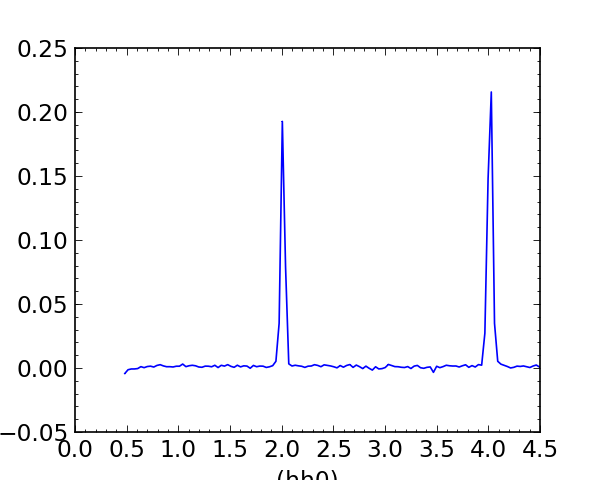

In [6]:
# Load data as a object and cut
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = r'30mK_0p25T_one30_sub_20k.hdf'
#fname = r'30mK_1T_two180-sub_20k_0T_5h5h10.hdf'
d25t  = loadE2_obj0(fpath,fname,infro=0)
#print(d25t.e.mean(axis=0))
#np.savetxt(os.path.join(fpath,'30mk_cut_peaks.dat'),d25t.e.mean(axis=0),fmt='%1.5f')

# Plot
xlabel = ['(hh0)','(00l)']
intAx = 0
mycut = cut2d(d25t,[0,4.5],[-0.2,0.2],1) #(002) and (004)
#mycut = cut2d(d25t,[0.5,1.5],[-0.5,0.5],intAx)
#mycut = cut2d(d25t,[3.5,4.5],[-0.5,0.5],intAx)# (004) peak
plt.figure(figsize=(5,4))
plt.errorbar(mycut.x, mycut.I, 0.01*mycut.e,capsize=0)

plt.xlabel(xlabel[intAx],size=14)
plt.ylabel('Intensity(a.u.)',size=14)
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
#plt.savefig(os.path.join(fpath,'30mk_cut_peaks.pdf'), bbox_inches="tight",verbose=True)
plt.show()

<IPython.core.display.Javascript object>


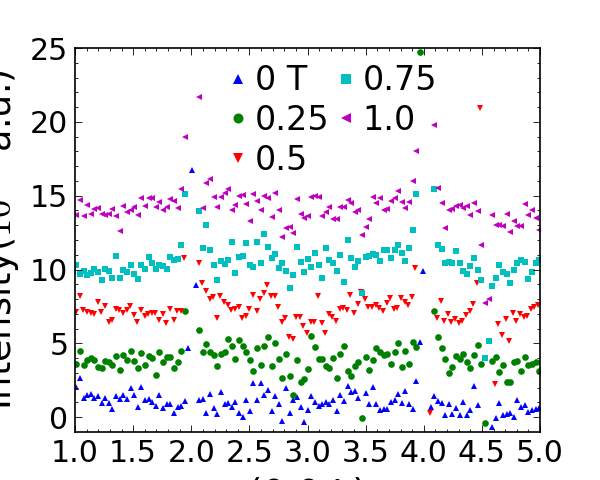

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0T_sub_20k.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1T_two180-sub_20k_0T_5h5h10.hdf


In [27]:
# Cut the 30mK data and plot spline
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/' 
fname = ['30mK_0T_sub_20k.hdf',
         '30mK_0p25T_one30_sub_20k.hdf',
         '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf',
         '30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf',
         '30mK_1T_two180-sub_20k_0T_5h5h10.hdf',
         '30mK_1p25T_sub_20k.hdf',
         '30mk_1p5T_one30_sub_20k_0T_5h5h10.hdf',
         '30mk_1p75T_one30_sub_20k_0T.hdf',
         '30mk_2T_one90-sub_20k_0T_5h5h10.hdf']
          
xlabel = ['(H -H 0)','(0 0 L)']
legs = ['0 T','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
markers = ['^','o','v', 's', '<', 'o', '8', 's', 'p']
colors =  ['g','bk','green','y','b','r','y','g','r','b']
xshift = [0,0,0.0002,0,-0.0002,0,0,0,0,0]
yshift = 3
intAx = 1 # 0: integrate ool, 1: integrate hho

intWidth = 0.2

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname):
    if idx==5:
        break
    dat  = loadE2_obj(fpath,fn,infro=0)
    
    # Cut along [ool] integrating around zero(hho) and all vertical
    #mycut = cut2d(dat,[0,5],[-intWidth,intWidth],1)   
    mycut = cut3d(dat, h_ho=[-0.5,0.5], ool=[0,5], hho=[-intWidth,intWidth], intaxs=[0,2]) 
    maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
    maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
    maskede = np.ma.masked_where(mycut.I==0, mycut.e)
    line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy+yshift*idx, 1e3*0.00001*maskede, marker=markers[idx], 
                                  markersize=4,fmt='o',mec='none',
                                  label=legs[idx], lw=0.3, capsize=0)
    
    # Cut along (hho) integrating around (oo1)/(003) and all vertical
    #mycut = cut3d(dat, h_ho=[-0.5,0.5], ool=[1.5,1.8], hho=[-5,5], intaxs=[0,1]) # (001)
#     mycut = cut3d(dat, h_ho=[-0.5,0.5], ool=[2.2,2.8], hho=[-5,5], intaxs=[0,1])# (003)
#     maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
#     maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
#     maskede = np.ma.masked_where(mycut.I==0, mycut.e)
#     line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy+yshift*idx, 1e3*0.00001*maskede, marker=markers[idx], markersize=4,fmt='o',
#                                   label=legs[idx], lw=0.3, capsize=0)
    
    # Cut along (hho) integrating 0-4(ool) excluding Bragg peaks and all vertical
    #mycut0 = cut2d(dat,[0.5,1.5],[-1.3,1.3],0)
    #mycut1 = cut2d(dat,[2.2,3.8],[-1.3,1.3],0)
    #maskedx = np.ma.masked_where(mycut0.I+mycut1.I==0, mycut0.x)
    #maskedy = np.ma.masked_where(mycut0.I+mycut1.I==0, (mycut0.I+mycut1.I)/2. )
    #line,caps,bars = plt.errorbar(maskedx,1e3*(maskedy+xshift[idx]), 1e3*0.0005*((mycut0.e**2+mycut1.e**2)/2)**0.5,
    #                              label=legs[idx], fmt='o',c=colors[idx], capsize=0)#  line, (errx_top, errx_bot, erry_top, erry_bot), (barsx, barsy) = errobj    
    
    # Cut along (hh0) integrating ool to get the 002 peak: too few data points! Use the 1500*1500*10 data
    #mycut = cut2d(dat,[1.8,2.2],[-1.3,1.3],0)
    #plt.errorbar(mycut.x, mycut.I, 0.001*mycut.e, label=legs[idx], fmt='-o', capthick=0)
    
    # Plot spline
    #from scipy import interpolate
    #spl = interpolate.UnivariateSpline(maskedx, 1e3*maskedy+yshift*idx, w=None, k=2, s=1)
    #plt.plot(maskedx, spl(maskedx),c=line.get_markerfacecolor())
    
plt.axis([1.,5,-1,25])
#plt.axis([1.,5,-2,35])
#plt.yscale("log", nonposx='clip'); 
plt.xlabel(xlabel[intAx],size=22)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=22)
plt.minorticks_on()
plt.tick_params(labelsize=20)
plt.xticks(color='k', size=18)
plt.yticks(color='k', size=18)
# get handles
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] for h in handles]
loc = [0.94,0.0]# [0.25,0.65]
# plt.gca().legend(handles, labels,loc=loc,ncol=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,markerscale=1.5,
#                  labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()

#plt.text(0.08,0.08,'Integrated width\n [-{0:}, {0:}](H -H 0)'.format(intWidth), fontsize=14, transform=plt.gca().transAxes)
#plt.savefig(os.path.join(fpath,'30mk_cut_along(00l)_linear1.pdf'), bbox_inches="tight",verbose=True)
plt.show()

In [35]:
plt.gca().legend(handles, labels,loc=[0.25,0.63],ncol=2,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()
plt.savefig(os.path.join(fpath,'30mk_cut_along(00l)_linear_all.pdf'), bbox_inches="tight",verbose=True)

<IPython.core.display.Javascript object>


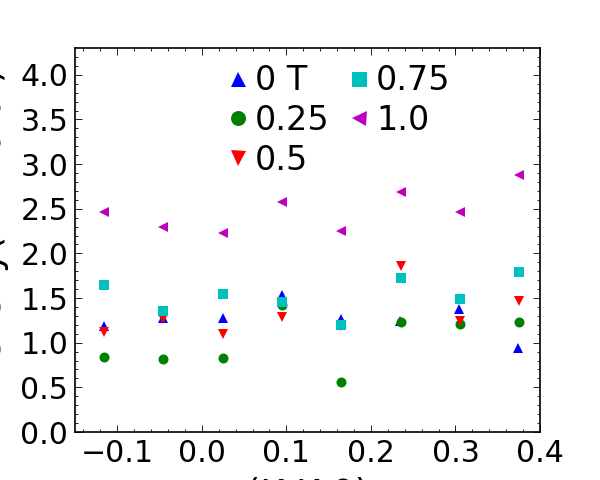

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0T_sub_20k.hdf
30mK_0T_sub_20k.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
30mK_0p25T_one30_sub_20k.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1T_two180-sub_20k_0T_5h5h10.hdf
30mK_1T_two180-sub_20k_0T_5h5h10.hdf


In [43]:
# Cut to get the vertical ax-I
xlabel = ['(K K 0)','(0 0 L)','(H -H 0)'] # (KK0) is vertical
#intAxs = (0,2) #h_ho is ax=0 (veritcal wavevector), ool is ax=1, hho is ax=2 
intAxs = (1,2) #h_ho is ax=0 (veritcal wavevector), ool is ax=1, hho is ax=2 
hhointWidth = 0.2

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname):
    if idx==5:
        break
    dat  = loadE2_obj(fpath,fn,infro=0)
    print(fn)
    # Cut along [ool] integrating around zero(hho)
    mycut0 = cut3d(dat, h_ho=[-1,1], ool=[1.2,1.8], hho=[-hhointWidth,hhointWidth], intaxs=intAxs)    
    mycut1 = cut3d(dat, h_ho=[-1,1], ool=[2.2,3.8], hho=[-hhointWidth,hhointWidth], intaxs=intAxs) 
    #mycut1 = cut3d(dat, h_ho=[-1,1], ool=[2.5,3.5], hho=[-hhointWidth,hhointWidth], intaxs=intAxs) 
    
    # Combine
    mycut = E2_data_1d(mycut0.x, (  mycut0.I + mycut1.I)/2., (mycut0.e+mycut1.e)/2.)
    #mycut = cut3d(dat, h_ho=[-1,1], ool=[1,1.8], hho=[-hhointWidth,hhointWidth], intaxs=intAxs) 
    
    maskedx = np.ma.masked_where(mycut.I==0, mycut.x)
    maskedy = np.ma.masked_where(mycut.I==0, mycut.I)
    maskede = np.ma.masked_where(mycut.I==0, mycut.e)
    line,caps,bars = plt.errorbar(maskedx, 1e3*maskedy, 1e3*0.00001*maskede,marker=markers[idx],mec='none',
                                  label=legs[idx], fmt='o',lw=0.5, capsize=0)

#plt.yscale("log", nonposx='clip');
plt.axis([-0.15,0.4,0,4.3])
#plt.axis([-0.2,0.4,0,4.8])
xlab = list(set([0,1,2])-set(intAxs))[0]
plt.xlabel(xlabel[xlab],size=22)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=22)

plt.minorticks_on()
plt.tick_params(labelsize=20)
plt.xticks(color='k', size=18)
plt.yticks(color='k', size=18) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

# remove the errorbar in the legend : http://swdg.io/2015/errorbar-legends/
from matplotlib import container
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
loc = [0.94,0.0]# [0.25,0.65]
plt.gca().legend(handles, labels,loc=loc,ncol=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.5).draggable()

#plt.savefig(os.path.join(fpath,'30mk_cut_along(h_ho)_linear1.pdf'), bbox_inches="tight",verbose=True)
plt.show()

In [45]:
plt.gca().legend(handles, labels,loc=[0.25,0.63],ncol=2,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,markerscale=1.5,
                 labelspacing=0.2, handletextpad=-0.5,columnspacing=-0.1).draggable()

plt.savefig(os.path.join(fpath,'30mk_cut_along(h_ho)_linear.pdf'), bbox_inches="tight",verbose=True)

<IPython.core.display.Javascript object>


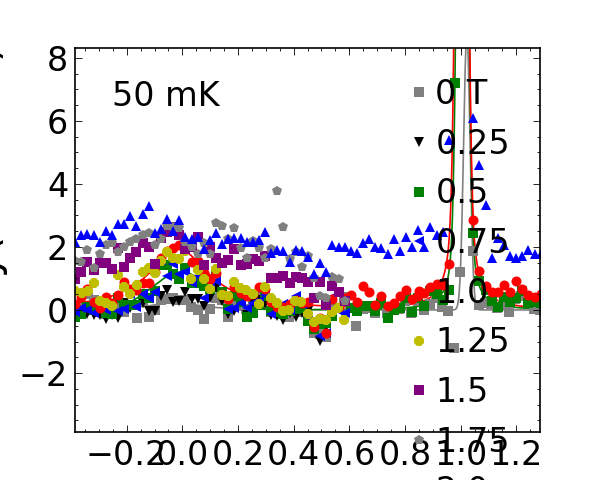

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0T_sub_20k.hdf
[ 7.92151046e-02 -2.59092459e-02  1.00000000e-01  1.00000000e+00
  2.55608292e-01  1.02233581e+00  1.37728024e-02  2.58311738e-10]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
[1.09423921e-01 1.00000000e-02 1.19367427e-01 1.09288530e-14]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
[ 3.14171774e-01 -3.18860370e-03  1.23105883e-01  9.50659924e-19
  1.46705205e+00  1.00667728e+00  1.68721970e-02  3.79745010e-01]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
[3.11589826e-01 5.65771885e-39 1.19429909e-01 1.44793179e-12]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1T_two180-sub_20k_0T_5h5h10.hdf
[ 0.79227677 -0.01336873  0.13077197  1.          2.03929196  1.00408893
  0.01686679  0.43020459]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1p25T_sub_

In [6]:
# Cut the 30mK data and fit the stick and (110) peaks with PV peaks 
# with shift data for bkg corr.
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = ['30mK_0T_sub_20k.hdf',
         '30mK_0p25T_one30_sub_20k.hdf',
         '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf',
         '30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf',
         '30mK_1T_two180-sub_20k_0T_5h5h10.hdf',
         '30mK_1p25T_sub_20k.hdf',
         '30mk_1p5T_one30_sub_20k_0T_5h5h10.hdf',
         '30mk_1p75T_one30_sub_20k_0T.hdf',
         '30mk_2T_one90-sub_20k_0T_5h5h10.hdf']
          
xlabel = ['(H -H 0)','(0 0 L)']
legs = ['0 T','0.25','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['grey','black','green','b','r','y','purple','grey','b']
markers = ['s','v', 's', '<', 'o', '8', 's', 'p','^','>']
xshift = np.array([0,      0.,     0.009,  0.015, 0,0,0,0,0])* 0
yshift = np.array([-0.0005,-0.0003,-0.0000,-0.0002,0,-0.0005,0,0,0]) + 0.00012
vshift = 0 # verical shift for plot
intAx = 0 # 0: integrate ool, 1: integrate hho

fitpars, fiterrs = [],[]

xplot0 = np.linspace(-0.5,0.5,1000,endpoint=True)
xplot1 = np.linspace(-0.5,1.3,2000,endpoint=True)
pknb = [2,1,2,1,2,1,1,1,1]

plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname):
    if idx==9:
        break
    d25t  = loadE2_obj(fpath,fn,infro=0)
       
    # Integrate 0-4(ool) excluding Bragg peaks
    mycut0 = cut2d(d25t,[1,1.8],[-0.5,1.3],0)
    mycut1 = cut2d(d25t,[2.2,3.8],[-0.5,1.3],0)

    x = mycut0.x + xshift[idx]
    y = 1e3*((   0*mycut0.I       +mycut1.I)/2.+yshift[idx])
    err = 1e3*0.0005*((mycut0.e**2+mycut1.e**2)/2)**0.5
    ymasked = np.ma.masked_where(mycut0.I+mycut1.I==0, y ) # mask the none values

    line,caps,bars = plt.errorbar(x, ymasked+vshift*idx, 0*err, marker=markers[idx],
                                  label=legs[idx], fmt='o',c=colors[idx],mec='none',capthick=0, capsize=0)
    #plt.scatter(mycut0.x,1e3*(masked+shift[idx]),label=legs[idx], marker=markers[idx],c=colors[idx],edgecolors='none',s=35)  
    
    # Peak fit
    params_0 = [0.8, 0., 0.2, 0.5]
    bounds = [[0,    -0.00, 0.1, 0],
              [np.inf,0.01, 0.5, 1]] # amplitude, pos, withd, frac

    if pknb[idx]==2:            
        params_0 = [0.8,     0., 0.2, 0.5,  50,  1.0, 0.1, 0.5]
        bounds = [ [0,    -0.05, 0.1, 0,      0, 0.9, 0.0, 0],
                   [np.inf,0.05, 0.2, 1, np.inf, 1.2, 0.4, 1]] # amplitude, pos, width, frac
    try:
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, pknb[idx], params), x, y, p0=params_0,
                               bounds=bounds)#, sigma=err, absolute_sigma=False)# if initio value is outside bounds, error
        perr = np.sqrt(np.diag(pcov))
        print(popt)
        fitpars.append(popt[:4])
        fiterrs.append(perr)
    except:
        print('Failed')
        
    if pknb[idx]!=1: 
        plt.plot(xplot1,wrapper_fit_func_PV(xplot1,pknb[idx],popt)+vshift*idx,c=colors[idx])

#plt.axis([-0.5,1.3,-1,4])
#plt.axis([-0.5,0.55,-0.49,5])
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=25)
plt.minorticks_on()
plt.tick_params(labelsize=18)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.text(0.08,0.85,'50 mK', fontsize=20, transform=plt.gca().transAxes)

# remove the errorbar in the legend : http://swdg.io/2015/errorbar-legends/
from matplotlib import container
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
plt.gca().legend(handles, labels,loc='best',scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5)

#plt.savefig(os.path.join(fpath,'30mk_cut_diffues.pdf'), bbox_inches="tight",verbose=True)
plt.show()


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[[ 7.92151046e-02 -2.59092459e-02  1.00000000e-01  1.00000000e+00]
 [ 1.09423921e-01  1.00000000e-02  1.19367427e-01  1.09288530e-14]
 [ 3.14171774e-01 -3.18860370e-03  1.23105883e-01  9.50659924e-19]
 [ 3.11589826e-01  5.65771885e-39  1.19429909e-01  1.44793179e-12]
 [ 7.92276771e-01 -1.33687268e-02  1.30771966e-01  1.00000000e+00]]


<IPython.core.display.Javascript object>


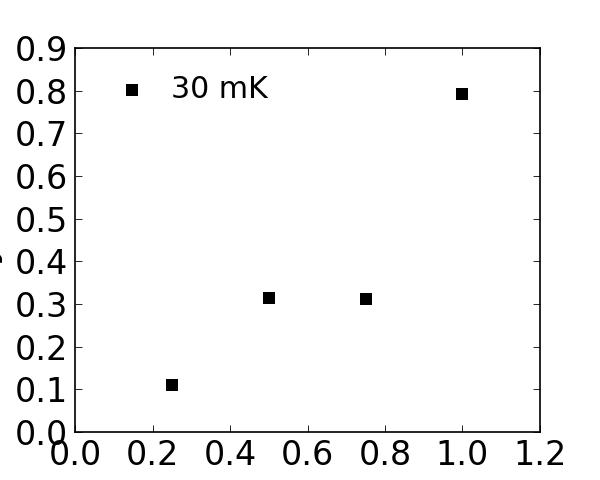

In [18]:
# Export I-H figure
Hs = np.linspace(0,2,num=9,endpoint=True)
print Hs
fitpars = np.array(fitpars)
print(fitpars)
plt.figure(figsize=(5,4))
plt.scatter(Hs[1:5],fitpars[1:5,0],c='k',label='30 mK',s=50, marker='s',linewidth=0,edgecolors=None) # set the first point to a different color
#plt.axis([-0.2,2.2,0,1])
plt.xlabel('Field (T)',size=25)
plt.ylabel('Intensity($10^2$ a.u.)',size=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

plt.legend(loc='best', frameon=False, scatterpoints=1,fontsize=18,handletextpad=0.3)
#plt.text(0.7,0.2,'(0 0 2)', fontsize=20, transform=plt.gca().transAxes)
#plt.savefig(os.path.join(fpath,'30mk_(002)_peak_int.pdf'), bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


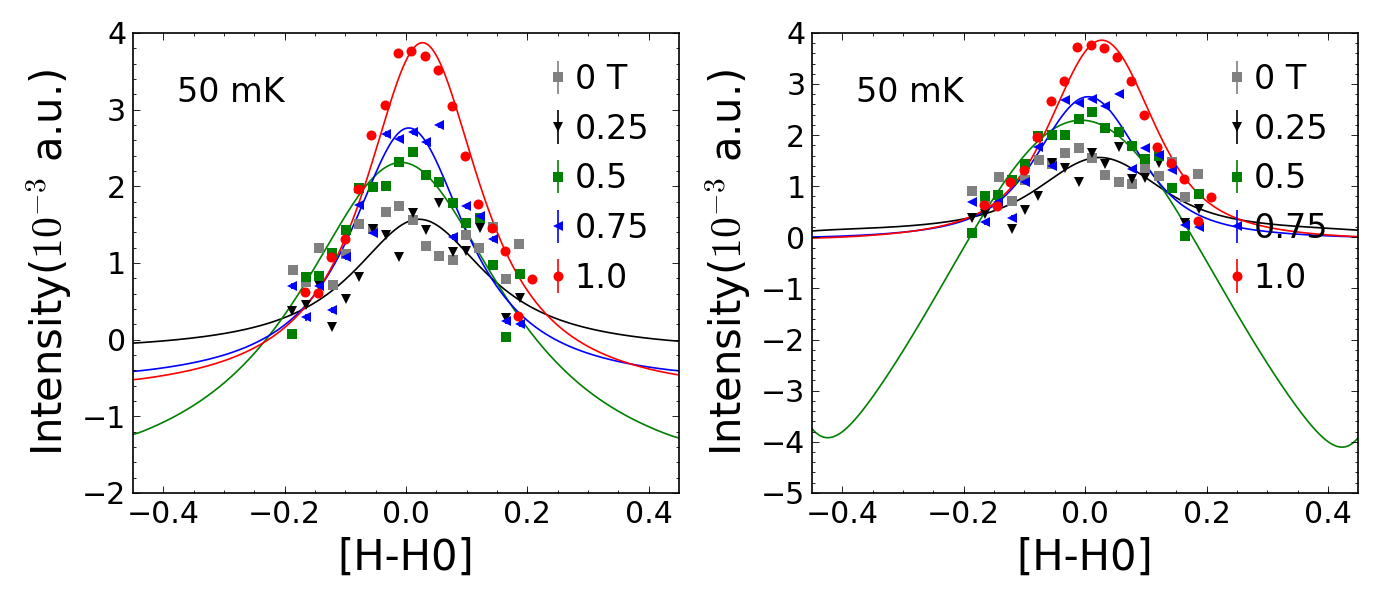

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0T_sub_20k.hdf
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
(9.223880871783225, 0.015946249948424984)
(13.37103449232771, 0.011201215177596743)
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
(5.794957526357462, 0.06247890433474299)
(3.358455915406451, 0.29019879081060856)
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
(10.751775292032802, 0.02671736150107257)
(18.885834826746663, 0.017001411100789694)
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1T_two180-sub_20k_0T_5h5h10.hdf
(10.826081110700356, 0.03651941206597966)
(18.280570032816936, 0.024452360465037407)


In [19]:
# Fit with lmfit for two sigma_gs=[0.02, 0.05]
from lmfit import Model, CompositeModel
from lmfit.lineshapes import lorentzian, gaussian
def insRes(x,sigma_g):
    return gaussian(x, amplitude=1, center=0, sigma=sigma_g)
def myLorentz(x, amplitude, center, sigma, const):
    return lorentzian(x, amplitude, center,sigma) + np.full_like(x, const)
def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

xshift = np.array([0, 0, 0., 0., 0.02,0.15,0,0,0,0])
yshift = np.array([0, 0,0.0002,0,-0.0002,0,-0.0005,0,0,0]) + 0.00012

# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0, sigma_g=0.02)
pars['const'].set(value=0,vary = True)
pars['center'].set(min=-0.05, max=0.05)
sigma_gs = [0.02, 0.05]

xplot0 = np.linspace(-0.5,0.5,1000,endpoint=True)# plot the fit

# fit this model to data array y
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11.5,5))
for idx, fn in enumerate(fname):
    if idx==5:
        break
    data  = loadE2_obj(fpath,fn,infro=0)
    
    mycut0 = cut2d(data,[1.2,1.8],[-0.2,0.2],0)
    mycut1 = cut2d(data,[2.2,3.8],[-0.2,0.2],0)
        
    x = mycut0.x + xshift[idx]
    y = 1e3 * (np.nanmean(np.vstack([mycut0.I, mycut1.I]),axis=0) + yshift[idx] )
    e = 1e3 * 0.0001*np.nanmean(np.vstack([mycut0.e, mycut1.e]), axis=0)/2.
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]    

    for ii in [0,1]:# check two simgam_g
        if idx!=0:
            pars['sigma_g'].set(value=sigma_gs[ii],vary = False)
            result =  mod.fit(y, params=pars, x=x)
            #print(result.fit_report())
            sigma, ampl = result.best_values['sigma'],result.best_values['amplitude']
            unit110 = 2*np.pi/(10.61/np.sqrt(2.))
            correL = 1/(unit110*sigma)
            print(correL,ampl)
            #axs[ii].text(0.05,0.8,'Corre Length\n%1.2f$\AA$'%correL, fontsize=10, transform=axs[ii,idx].transAxes)
            axs[ii].errorbar(x, y, e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0)
            axs[ii].plot(xplot0, result.eval(x=xplot0)/22, c=colors[idx]) # '/22': more X points larger Y due to Conv method!!!
            
            # plot results +'%1.2f'%correL
            #axs[ii].plot(x, result.best_fit, c=colors[idx])
            #comps = result.eval_components(x=x)
            #axs[ii].plot(x, 25*comps['myLorentz'], 'k--',label='Lorentz')
            #axs[ii].plot(x, 0.2*comps['insRes'], 'r--',label='insRes='+'%1.2f'%pars['sigma_g'].value)
            
        else:
            axs[ii].errorbar(x, y, e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0)
        
for ii in [0,1]:        
    axs[ii].set_xlim([-0.45,0.45]); 
    #axs[ii].set_ylim([-0.49,3.5]); 
    #axs[ii].xaxis.set_major_locator(plt.MaxNLocator(5))
    axs[ii].minorticks_on()
    
    axs[ii].tick_params(labelsize=18)
    #axs[ii].Tick(axes='both',size=20)
    
    axs[ii].set_xlabel('[H-H0]',size=25)
    axs[ii].set_ylabel('Intensity($10^{-3}$ a.u.)',size=25)
    
    #axs[ii].text(0.08,0.8,'50 mK\n$\sigma_G=$'+str(sigma_gs[ii]), fontsize=20, transform=axs[ii].transAxes)
    axs[ii].text(0.08,0.85,'50 mK', fontsize=20, transform=axs[ii].transAxes)
    axs[ii].legend(loc=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()
plt.tight_layout()
#plt.savefig(os.path.join(fpath,'30mk_cut_diffues00.pdf'), bbox_inches="tight",verbose=True)
plt.show()


<IPython.core.display.Javascript object>


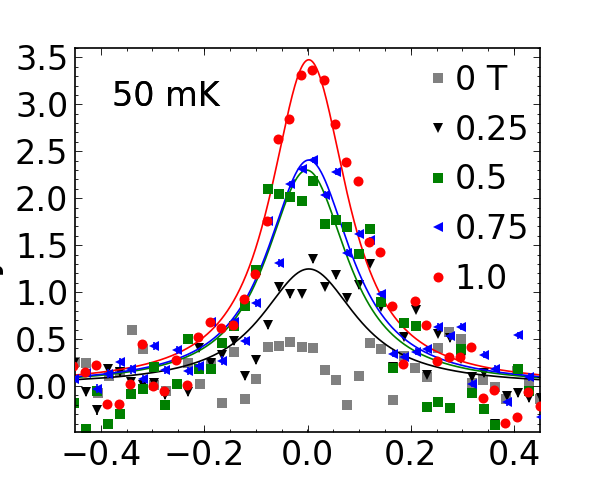

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0T_sub_20k.hdf
4.665801252654151
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
11.267715837968359
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
13.48066069866212
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
13.085887462027912
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1T_two180-sub_20k_0T_5h5h10.hdf
14.595605596118704


In [23]:
# Fit with lmfit for one sigma_gs=[0.02]
xshift = np.array([0,0, 0., 0., 0.02,0.15,0,0,0,0])
yshift = np.array([-0.0003,0,0.00022,0.0001,-0.0001,0,-0.0005,0,0,0])

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(5,4))
pars['const'].set(value=0,vary=False)
pars['center'].set(min=-0.002, max=0.002)
sigma_gs=0.02

for idx, fn in enumerate(fname):
    if idx==5:
        break
    data  = loadE2_obj(fpath,fn,infro=0)
    mycut0 = cut2d(data,[0.5, 1.8],[-0.5,0.5],0)
    mycut1 = cut2d(data,[2.2,3.8],[-0.5,0.5],0)
        
    x = mycut0.x + xshift[idx]
    if idx==0:
        y = 1e3 * (np.nanmean(np.vstack([mycut0.I*0, mycut1.I]),axis=0) + yshift[idx] )
    else:
        y = 1e3 * (np.nanmean(np.vstack([mycut0.I, mycut1.I]),axis=0) + yshift[idx] )
    e = 1e3 * 0.0001*np.nanmean(np.vstack([mycut0.e, mycut1.e]), axis=0)/2.
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]    

    pars['sigma_g'].set(value=sigma_gs, vary=False)
    result =  mod.fit(y, params=pars, x=x)

    sigma = result.best_values['sigma']
    unit110 = 2*np.pi/(10.61/np.sqrt(2.))
    correL = 1/(unit110*sigma)
    print(correL)
    #axs[ii].text(0.05,0.8,'Corre Length\n%1.2f$\AA$'%correL, fontsize=10, transform=axs[ii,idx].transAxes)

    # plot results
   
    if idx==0:
        from scipy.signal import savgol_filter
        axs.errorbar(x, savgol_filter(y, window_length=3, polyorder=2), e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0,zorder=idx)
    else:
        axs.errorbar(x, y, e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0,zorder=idx)
        axs.plot(xplot0, result.eval(x=xplot0)/22, c=colors[idx]) # '/22': more X points larger Y due to Conv method!!!
        
plt.axis([-0.45,0.45,-0.49,3.6])
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=25)
plt.minorticks_on()
plt.tick_params(labelsize=18)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.text(0.08,0.85,'50 mK', fontsize=20, transform=plt.gca().transAxes)

#axs[ii].text(0.08,0.8,'50 mK\n$\sigma_G=$'+str(sigma_gs[ii]), fontsize=20, transform=axs[ii].transAxes)
axs.text(0.08,0.85,'50 mK', fontsize=20, transform=axs.transAxes)
#axs.legend(loc=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()

# remove the errorbar in the legend : http://swdg.io/2015/errorbar-legends/
from matplotlib import container
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
plt.gca().legend(handles, labels,loc=[0.68,0.32],scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5)

#plt.savefig(os.path.join(fpath,'30mk_cut_diffuse.pdf'), bbox_inches="tight",verbose=True)
plt.show()


<IPython.core.display.Javascript object>


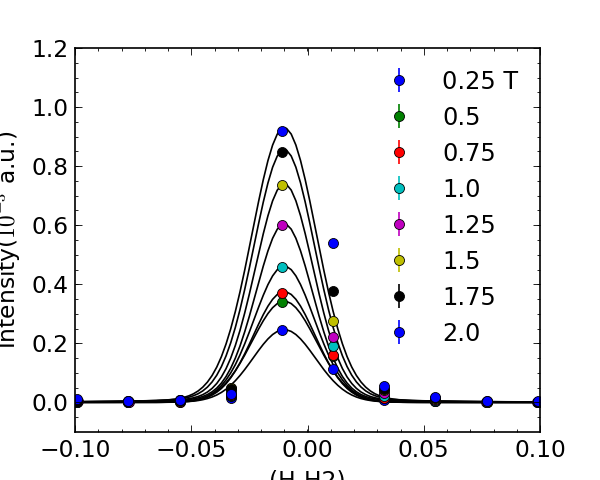

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_0p25T_one30_sub_20k.hdf
[ 0.00845379 -0.01        0.01588126  0.04339404]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf
[ 0.01193573 -0.01        0.01623879  0.02190361]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf
[ 0.01253855 -0.01        0.01560214  0.01900841]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1T_two180-sub_20k_0T_5h5h10.hdf
[ 0.01547172 -0.01        0.01538617  0.06937869]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1p25T_sub_20k.hdf
[ 0.01983536 -0.01        0.01462611  0.15690283]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_1p5T_one30_sub_20k_0T_5h5h10.hdf
[ 0.02469037 -0.01        0.01491856  0.14836391]
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_1p75T_one30_sub_20k_0T.hdf
[ 0.03004935 -0.01        0.01573454  0.14049043]
D:\5_Neutron Scatterin

In [206]:
# Cut the 30mK data and fit the (002) peaks with shift data for bkg corr.
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = ['30mK_0p25T_one30_sub_20k.hdf',
         '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf',
         '30mk_0p75T_one30_sub_20k_0T_5h5h10.hdf',
         '30mK_1T_two180-sub_20k_0T_5h5h10.hdf',
         '30mK_1p25T_sub_20k.hdf',
         '30mk_1p5T_one30_sub_20k_0T_5h5h10.hdf',
         '30mk_1p75T_one30_sub_20k_0T.hdf',
         '30mk_2T_one90-sub_20k_0T_5h5h10.hdf']
          
xlabel = ['(H-H2)','(00L)']
legs = ['0.25 T','0.5','0.75','1.0','1.25','1.5','1.75','2.0']
colors = ['green','y','b','r','y','g','r','b']
shift = [0,0.0002,0,-0.0002,0,0,0,0,0] # 
intAx = 0 # 0: integrate ool, 1: integrate hho
xplot = np.linspace(-1,1,1000,endpoint=True)
fitpars = []
plt.figure(figsize=(5,4))
for idx, fn in enumerate(fname):
    if idx==8:
        break
    data  = loadE2_obj(fpath,fn,infro=0)
    
    # Integrate ool to get the 002 peak
    mycut = cut2d(data,[1.8,2.2],[-1.3,1.3],0)
    plt.errorbar(mycut.x, mycut.I, 0.001*mycut.e, label=legs[idx], fmt='o', capthick=0)
    
    # Find peak and fit
    x = mycut.x
    y = mycut.I 
    err = mycut.e
    
    indexes = peakutils.indexes(y, thres=0.1, min_dist=10)
    #print(idx, indexes, x[indexes], y[indexes])
    
    N = len(indexes)
    if N!=0:    
        params_0, lowBound, highBound = [], [], []
        lb = [0,     -0.02, 0.001,0] # amplitude, pos, withd, frac; must put narrow constraint for fitting high field data
        hb = [np.inf,-0.01, 0.5,  1]
        for j in xrange(N):
            params_0.append([y[indexes[j]], x[indexes[j]], 0.05, 0.3]) # for PV
            lowBound += lb # lowBound.extend(lb) is better
            highBound += hb
            
        params_0 = np.asarray(params_0).ravel()
        bounds = [lowBound,highBound]
        #print np.all((params_0 >= lowBound) & (params_0 <= highBound))
        #print(params_0, '\n', bounds)
        try:
            popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, N, params), x, y, p0=params_0,
                                   bounds=bounds, sigma=err, absolute_sigma=True)# if initio value is outside bounds, error
            perr = np.sqrt(np.diag(pcov))
            plt.plot(xplot,wrapper_fit_func_PV(xplot,N,popt),c='black')
            print(popt)
            fitpars.append(popt)
        except:
            print('Failed')
            
#plt.axis([-0.5,1.2,-1,5])
plt.axis([-0.1,0.1,-0.1,1.2])
plt.xlabel(xlabel[intAx],size=14)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=14)
plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14) # plt/ax.tick_params(axis='both', which='major', labelsize=10)

plt.legend(loc='best',numpoints=1,frameon=False)
plt.show()


[[ 0.00845379 -0.01        0.01588126  0.04339404]
 [ 0.01193573 -0.01        0.01623879  0.02190361]
 [ 0.01253855 -0.01        0.01560214  0.01900841]
 [ 0.01547172 -0.01        0.01538617  0.06937869]
 [ 0.01983536 -0.01        0.01462611  0.15690283]
 [ 0.02469037 -0.01        0.01491856  0.14836391]
 [ 0.03004935 -0.01        0.01573454  0.14049043]
 [ 0.0340166  -0.01        0.01655851  0.11212323]]


<IPython.core.display.Javascript object>


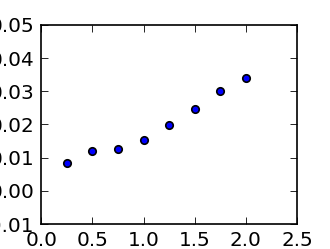

In [207]:
# Plot the fitted peak area
Hs = [0.25,0.5,0.75,1.0,1.25,1.5,1.75,2]
fitpars = np.asarray(fitpars).reshape((-1,4))
print(fitpars)
plt.figure(figsize=(5,4))
plt.scatter(Hs,fitpars[:,0])
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_2T_one90-sub_20k_0T_5h5h10.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
((500L, 500L), 1)


<IPython.core.display.Javascript object>


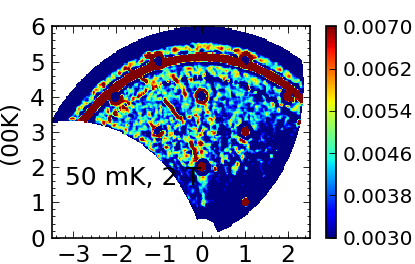

In [208]:
# 30mK 2T data: 2D plot
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '30mk_2T_one90-sub_20k_0T_5h5h10.hdf'
x, y, z, data  = loadE2(fpath,fname)

# Plot 3D with Mayavi
#xyzLens, xyzBins = [500,500,10], [5,5,2]
#x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
#contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
#extent = np.array([x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),(z1.max()+4)])
#vmin,vmax = 0.002,0.008
#mfig,ax = myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,0.5)
#ax.axes.y_axis_visibility = False

# Plot 2D with matplotlib
vmin,vmax = 0.003,0.007
smooth = 1
axlim = [-3.5,2.5,0,6]
fig, ax, cb = sum_plot2D(x, y, data,smooth,vmin,vmax,axlim)
ax.text(-3.2,1.5,'50 mK, 2 T', fontsize=15)
ax.grid('off')
cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
cb.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')
#fig.savefig(os.path.join(fpath,fname.replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  
plt.show()

# 450 mK data: 2D and 1D plots (normal plots; use the ones plotted with 30mK data above)
 <a id='plot_cut_450mk'></a>

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_0p5T_one90_sub_20k_0T_5h5h10.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
('raw data', (10L, 500L, 500L))
('binned data', (100L, 100L, 5L))
((500L, 500L), 1)


<IPython.core.display.Javascript object>


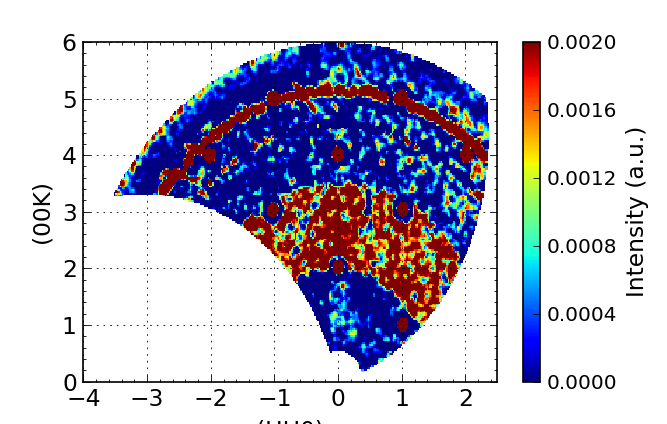

In [34]:
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '450mk_0p5T_one90_sub_20k_0T_5h5h10.hdf'
x, y, z, data  = loadE2(fpath,fname)

xyzLens, xyzBins = [500,500,10], [5,5,2]
x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
extent = np.array([x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),(z1.max()+4)])
vmin,vmax = 0.003,0.005
#mfig,ax = myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,0.5)

# Sum to a 2D data and plot with pcolor
# Plot 2D with matplotlib
smooth = 1
axlim = [-4,2.5,0,6]
vmin,vmax = 0.000,0.002
fig, ax, cb = sum_plot2D(x, y, data,smooth,vmin,vmax,axlim)
cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
cb.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')
#fig.savefig(os.path.join(fpath,fname.replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_0p5T_one90_sub_20k_0T_5h5h_2D.hdf
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Data', (500L, 500L))
(3, u'Sigma', (500L, 500L))


<IPython.core.display.Javascript object>


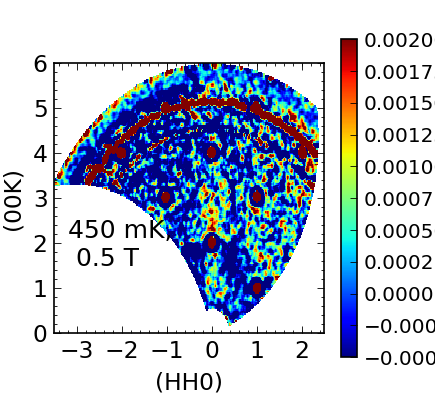

In [35]:
# Plot the original 2D data 
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '450mk_0p5T_one90_sub_20k_0T_5h5h_2D.hdf'
x, y, data  = loadE2_2D(fpath,fname)
#print(x)
Z,s,exitflag,Wtot = smoothn(data,s=1.) 
Zm = np.ma.masked_where(data==0,Z)# mask Nan values then plot in white color

fig = plt.figure()
ax = plt.gca()
ax.set_aspect(1)
# pcolor plot
pcol = plt.pcolormesh(x, y, Zm, cmap='jet',linewidth=0,rasterized=True,vmin=-0.0005, vmax=0.002)
pcol.set_edgecolor('face') # remove the white lines in the plot

ax.text(-3.2,1.5,'450 mK,\n 0.5 T', fontsize=15)

plt.axis([-3.5,2.5,0,6])
plt.xlabel('(HH0)',size=14)
plt.ylabel('(00K)',size=14)
plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)
ax.grid('off')
# set colorbar and its properties
cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
cb.ax.tick_params(labelsize=12)
#plt.title('Pcolormesh grid data')
#fig.savefig(os.path.join(fpath,fname.replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_2T_sub_20k_0T_5h5h10.hdf
[u'Axes0', u'Axes1', u'Axes2', u'Data', u'Sigma']
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Axes2', (10L,))
(3, u'Data', (10L, 500L, 500L))
(4, u'Sigma', (10L, 500L, 500L))
('raw data', (10L, 500L, 500L))
('binned data', (100L, 100L, 5L))
((500L, 500L), 0.8)


<IPython.core.display.Javascript object>


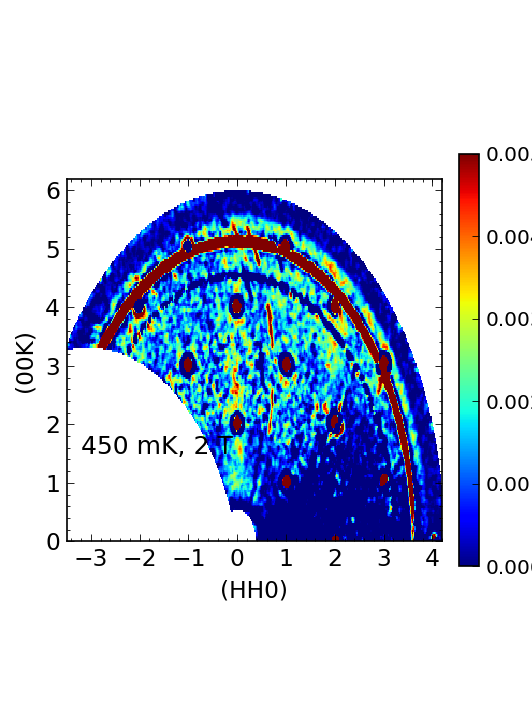

In [36]:
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '450mk_2T_sub_20k_0T_5h5h10.hdf'
x, y, z, data  = loadE2(fpath,fname)

xyzLens, xyzBins = [500,500,10], [5,5,2]
x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
extent = np.array([x1.min(),x1.max(),y1.min(),y1.max(),z1.min(),(z1.max()+4)])
vmin,vmax = 0.0,0.005
#mfig,ax = myiso_surface(x1,y1,z1,data_view,contours,extent,vmin,vmax,0.5)

# Plot 2D with matplotlib
axlim = [-3.5,4.2,-3.5,6.2];# for the full range
axlim = [-3.5,4.2,0,6.2];
smooth = 0.8
fig, ax, cb = sum_plot2D(x,y,data,smooth,vmin,vmax,axlim)
plt.gca().set_aspect(1.2)
ax.grid('off')
ax.text(-3.2,1.5,'450 mK, 2 T', fontsize=15)
cb.remove()# remove the old cb because it is to long; and modify it also diffecult
cb = plt.colorbar(fraction=0.05, pad=0.04, shrink=1,aspect=20)

cb.set_ticks([x for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)])
cb.ax.set_yticklabels(['{:.4f}'.format(x) for x in np.arange(vmin, vmax+(vmax-vmin)/5.,(vmax-vmin)/5.)], fontsize=12)#, weight='bold')
#fig.savefig(os.path.join(fpath,fname.replace('.hdf','.pdf')), bbox_inches="tight",verbose=True)  
plt.show()

D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_0T_sub_20k_0T_5h5h10_2D.hdf
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Data', (500L, 500L))
(3, u'Sigma', (500L, 500L))
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_0p5T_one90_sub_20k_0T_5h5h_2D.hdf
(0, u'Axes0', (500L,))
(1, u'Axes1', (500L,))
(2, u'Data', (500L, 500L))
(3, u'Sigma', (500L, 500L))
D:\5_Neutron Scattering\6_E2_April_2015\field_along110/450mk_2T_sub_20k_0T_5h5h10.hdf


<IPython.core.display.Javascript object>


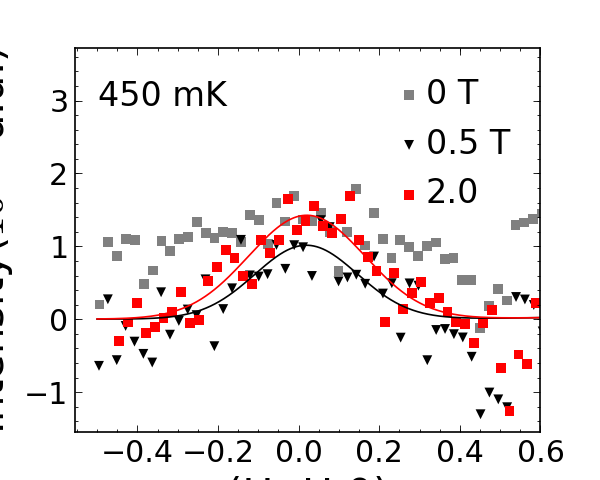

((82L,), (82L,))
[ 1.44352598e+00 -2.00000000e-02  3.00000000e-01  1.00000000e+00
  1.44397658e+00  1.04902242e+00  4.00000000e-01  4.59704943e-11]
((82L,), (82L,))
[3.23329158e-01 1.89049869e-02 1.50094968e-01 1.03433114e-28
 1.67711001e+00 1.00869021e+00 1.62795626e-02 4.41001231e-01]
((82L,), (82L,))
[5.14832011e-01 2.00000000e-02 1.69995913e-01 6.61668719e-15
 1.99408923e+00 1.05440506e+00 1.67856427e-02 4.31053191e-01]


In [53]:
# Cut and fit the stick and (110) peaks
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/' 

fname = '450mk_0T_sub_20k_0T_5h5h10_2D.hdf'
x, y, data  = loadE2_2D(fpath,fname)
data0 = E2_data(x, y, 0, 0, 0, data, data/100)
fname = '450mk_0p5T_one90_sub_20k_0T_5h5h_2D.hdf'
x, y, data  = loadE2_2D(fpath,fname)
data1 = E2_data(x, y, 0, 0, 0, data, data/100)
fname = '450mk_2T_sub_20k_0T_5h5h10.hdf'
data2 = loadE2_obj(fpath,fname)

xlabel = ['(H -H 0)','(0 0 L)']
legs   = ['0 T','0.5 T','2.0']
colors = ['grey','black','r']
xshift = [0, 0,     0.05]
yshift = [0, 0.0003, -0.001]
intAx = 0 # 0: integrate ool, 1: integrate hho

xplot = np.linspace(-0.5,1.2,2000,endpoint=True)
pknb = [2, 2, 2]
plt.figure(figsize=(5,4))

for idx, fn in enumerate([data0,data1,data2]):     
    # Integrate 0-4(ool) excluding Bragg peaks
    mycut0 = cut2d(fn,[1.2,1.7],[-0.5,1.3],0)
    mycut1 = cut2d(fn,[2.2,3.8],[-0.5,1.3],0)
    mycut0.x = mycut0.x+ xshift[idx]
    masked = np.ma.masked_where( mycut0.I+mycut1.I==0, (mycut0.I+mycut1.I)/2. )
    #line,caps,bars = plt.errorbar(mycut0.x,1e3*(masked+shift[idx]), 1e3*0.0002*((mycut0.e**2+mycut1.e**2)/2)**0.5,
    #                              label=legs[idx], fmt='o',c=colors[idx],mec='none', capthick=0)
    plt.scatter(mycut0.x,1e3*(masked+yshift[idx]), label=legs[idx], marker=markers[idx],c=colors[idx],edgecolors='none',s=35)
   
    # Find peak and fit
    x = mycut0.x
    y = 1e3*((mycut0.I+mycut1.I)/2.+yshift[idx])
    err = 1e3*0.0005*((mycut0.e**2+mycut1.e**2)/2)**0.5,
    print(x.shape,y.shape)
          
    params_0 = [0.8,     0., 0.2, 0.5,  50,  1.0, 0.1, 0.5]
    bounds = [ [0,    -0.02, 0.1, 0,      0, 0.9, 0.0, 0],
               [np.inf,0.02, 0.3, 1, np.inf, 1.2, 0.4, 1]] # amplitude, pos, withd, frac
    try:
        popt, pcov = curve_fit(lambda x, *params: wrapper_fit_func_PV(x, pknb[idx], params), x, y, p0=params_0,
                               bounds=bounds)#, sigma=err, absolute_sigma=False)# if initio value is outside bounds, error
        perr = np.sqrt(np.diag(pcov))
        print(popt)
    except:
        print('Failed')
    if idx!=0:    
        plt.plot(xplot,wrapper_fit_func_PV(xplot,pknb[idx],popt),c=colors[idx])

    
#plt.axis([-0.5,0.55,-0.25,1.7])
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=25)
plt.minorticks_on()
plt.tick_params(labelsize=20)
plt.xticks(color='k', size=18)
plt.yticks(color='k', size=18) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.text(0.05,0.85,'450 mK', fontsize=20, transform=plt.gca().transAxes)
plt.legend(loc='best',scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()    
#plt.savefig(os.path.join(fpath,'450mk_cut.pdf'), bbox_inches="tight",verbose=True)
plt.show()

<IPython.core.display.Javascript object>


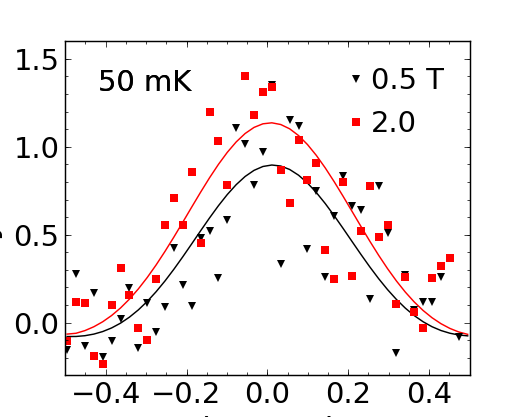

0.11666030379540984 10.235225483360546
0.008175363253123622 146.05400119036233


In [118]:
# Fit with lmfit for one sigma_gs=[0.02]
from lmfit import Model, CompositeModel
from lmfit.lineshapes import lorentzian, gaussian
def insRes(x,sigma_g):
    return gaussian(x, amplitude=1, center=0, sigma=sigma_g)
def myLorentz(x, amplitude, center, sigma, const):
    return lorentzian(x, amplitude, center,sigma) + np.full_like(x, const)
def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(insRes), Model(myLorentz), convolve)
pars = mod.make_params(amplitude=0.01, center=0.0, sigma=0.1, const=0.0, sigma_g=0.02)

pars['const'].set(value=0,vary =True)
pars['center'].set(min=-0.002, max=0.002,vary=True)
pars['sigma'].set(min=0.008, max=0.15)

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(5,4))

for idx, fn in enumerate([data0,data1]):     
    mycut0 = cut2d(fn,[0.5,1.5],[-0.5,0.5],0)
    mycut1 = cut2d(fn,[2.2,3.8],[-0.5,0.5],0)
             
    x = mycut0.x
    y = 1e3 * (np.nanmean(np.vstack([mycut0.I, mycut1.I]),axis=0) + yshift[idx])
    e = 1e3 * 0.0001*np.nanmean(np.vstack([mycut0.e, mycut1.e]), axis=0)/2.
    mask = np.where(~np.isnan(y))
    x, y, e = x[mask],y[mask],e[mask]    

    result =  mod.fit(y, params=pars, x=x)

    sigma = result.best_values['sigma']
    unit110 = 2*np.pi/(10.61/np.sqrt(2.))
    correL = 1/(unit110*sigma)
    print(sigma,correL)
    
    # plot results +'%1.2f'%correL
    axs.errorbar(x, y, 0*e, label=legs[idx], fmt=markers[idx],c=colors[idx],mec='none', capsize=0)
    axs.plot(x, result.best_fit, c=colors[idx]) # '/22': more X points larger Y due to Conv method!!!
      
plt.axis([-0.5,0.5,-0.3,1.6])
plt.xlabel(xlabel[intAx],size=25)
plt.ylabel('Intensity($10^{-3}$ a.u.)',size=25)
plt.minorticks_on()
plt.tick_params(labelsize=18)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20) # plt/ax.tick_params(axis='both', which='major', labelsize=10)
plt.text(0.08,0.85,'50 mK', fontsize=20, transform=plt.gca().transAxes)

#axs[ii].text(0.08,0.8,'50 mK\n$\sigma_G=$'+str(sigma_gs[ii]), fontsize=20, transform=axs[ii].transAxes)
axs.text(0.08,0.85,'50 mK', fontsize=20, transform=axs.transAxes)
axs.legend(loc=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5).draggable()

# remove the errorbar in the legend : http://swdg.io/2015/errorbar-legends/
from matplotlib import container
handles, labels = plt.gca().get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
plt.gca().legend(handles, labels,loc=1,scatterpoints=1,numpoints=1,frameon=False,fontsize=20,handletextpad=-0.5)

#plt.savefig(os.path.join(fpath,'30mk_cut_diffues00.pdf'), bbox_inches="tight",verbose=True)
plt.show()


# Plot 3D  <a id='plot_3D'></a>

In [30]:
# Ｐｌｏｔ　ｔｈｅ　３Ｄ　ｃａｌｃｕｌａｔｅｄ　ｅｎｅｒｇｙ－ｉｎｔｅｇｒａｔｅｄ　ｓｐｉｎ　ｗａｖｅ　ｓｃａｔｔｅｒｉｎｇ
from mayavi import mlab
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = 'nzo_spinw_eInt_3dQ_0.3T.txt'

filedir = os.path.join(fpath,fname); print(filedir)

# prepare the x y coordinate: both are [-4,4] and 10 points, the z: [0,0.8] 9 points
xy = np.linspace(-4,4,101,endpoint=True)
z = np.linspace(0,0.8,9,endpoint=True)
x, y, z = np.meshgrid(xy,xy,z,indexing='ij')  
print(np.shape(x),np.shape(y),np.shape(z))

rawd = np.genfromtxt(filedir)
data  = np.reshape(rawd/rawd.max(),[9,101,101]).transpose((2,1,0))
print(data.shape, xy.shape)

smooth = 5
Z,s,exitflag,Wtot = smoothn(data,s=5) 
data = np.ma.masked_where(data==0,Z)# mask Nan values then plot in white color

#use iso_surface
%gui qt
mlab.figure(bgcolor=(1,1,1), fgcolor=(0.,0.,0.))
grid=mlab.pipeline.scalar_field(x,y,z,data)

#extend: shape of the volume but the axis lable changes also. Axes range could change the lable back.
isos = mlab.pipeline.iso_surface(grid,opacity=0.5,transparent=True,
                          vmin=0.4,vmax=0.6,extent=[-4,4,-4,4,0,2],
                          contours=50)
mlab.outline()

ax = mlab.axes(xlabel=r"[H,H,0]",ylabel="[0,0,L]",zlabel="[K,-K,0]",
              nb_labels=5,ranges=[-4,4,-4,4,0,0.8])
ax.label_text_property.font_size = 100
ax.axes.font_factor = 2
ax.axes.label_format = '%1.1f'
ax.label_text_property.bold = False
ax.label_text_property.italic = False
ax.label_text_property.color = (.0, .0, .0)
ax.property.color = (1.0, 1.0, 1.0) 

cb = mlab.colorbar(orientation='horizontal',nb_labels=5, label_fmt='%1.2f')
cb.scalar_bar_representation.position = [0.1, 0.9]
cb.scalar_bar_representation.position2 = [0.8, 0.08]

mlab.show()

In [34]:
# old
#####Ｂｉｎｎｉｎｇ　ｄａｔａ: reshape, mean along the aixs having data points to bin. 
#The order axis to mean: from the large no to low no
hf=h5py.File(r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mK_1p25T_sub_20k.hdf')

fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf'
hf = h5py.File(os.path.join(fpath,fname))

#bin size
xlen=500;xbin=5
ylen=500;ybin=5
zlen=10;zbin=2
#read data
x0, y0, z0, data0 = hf[u'Axes0'][0:], hf[u'Axes1'][0:], hf[u'Axes2'][0:], hf[u'Data'][0:]
#bining
x1=x0.reshape(xlen/xbin,xbin).mean(axis=1)
print("x1",x1.shape)
y1=y0.reshape(ylen/ybin,ybin).mean(axis=1)
print("y1",y1.shape)
z1=z0.reshape(zlen/zbin,zbin).mean(axis=1)
print("z1",z1.shape)

print("raw data",np.shape(data0))
data_view=data0.transpose((2,1,0)).reshape(500/xbin,xbin,500/ybin,ybin,10/zbin,zbin).mean(axis=5).mean(axis=3).mean(axis=1)
print("binned data",data_view.shape)
#tol = 1e-5
#data_view[abs(data_view) < tol] = 0.0
#print(np.shape(data.reshape(5,2,100,5,100,5)))

x1 (100L,)
y1 (100L,)
z1 (5L,)
raw data (10L, 500L, 500L)
binned data (100L, 100L, 5L)


In [8]:
#　Ｐｌｏｔ　ｗｉｔｈ　ｔｈｅ　ｉｎｄｅｘ　ａｓ　the xyz corrdinates
%gui qt

# plot the raw data as volume
#mlab.pipeline.volume(mlab.pipeline.scalar_field(hf[u'Data'][0:]),vmin=0, vmax=0.015)

# plot contur of binned data
mlab.contour3d(data_view,opacity=0.5,transparent=True,vmin=-0.0001,vmax=0.007,contours=[-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007])

# plot volume of binned data
#mlab.pipeline.volume(mlab.pipeline.scalar_field(data_view),vmin=0, vmax=0.006)
#mlab.colorbar(orientation='vertical')

# Try mask some data point but volume function not allow
#mask_reg=np.zeros_like(data_view).astype(bool)
#mask_reg[np.where(data_view>0)]=True
#print(np.shape(mask_reg))
#mask_reg.tofile('D:/5_Neutron Scattering/6_E2_April_2015/output.txt', sep = ' ')

In [37]:
#plot with moving plane
mlab.pipeline.volume(mlab.pipeline.scalar_field(data_view),vmin=-0.001, vmax=0.008)
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(data_view),vmin=0, vmax=0.015,
                            plane_orientation='z_axes',
                            slice_index=10)
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(data_view),vmin=0, vmax=0.015,
                            plane_orientation='x_axes',
                            slice_index=10)
mlab.outline()

[u'int', u'x', u'y', u'z']


In [57]:
#Ｆｏｒ　９０　ｄｅｇ　ｓｃａｎ Ｐｌｏｔ　ｗｉｔｈ　ｔｈｅ　ｃｏｏｒｄｉｎａｔe　ｏｆ　ｄａｔａ
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = '30mk_0p5T_one90_sub_20K_0T_two180_5h5h10.hdf'

x, y, z, data  = loadE2(fpath,fname)
xyzLens, xyzBins = [500,500,10], [5,5,2]
x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)
print(data_view.shape)

# set the data zero for Q>4.4 out of the powder ring
x2, y2 = np.meshgrid(x1,y1, indexing='ij') 
rad = np.sqrt(2*x2**2 + y2**2)
rad = rad[:,:,np.newaxis] # for np.where
data_view = np.where( (rad<4.4) & (data_view<0.01),data_view,0.0)# select Q and intensity
print(data_view.shape)
#print(z1[np.sqrt(x2**2+y2**2)>rr,:])

# Export to the binned data to a file
# h5f = h5py.File(r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10_binned1.hdf','w')
# #g1 = h5f.create_group('xyzInt')
# h5f.create_dataset('x', data=x1)
# h5f.create_dataset('y', data=y1)
# h5f.create_dataset('z', data=z1)
# h5f.create_dataset('int', data=data_view)
# print(h5f.keys())
# h5f.close()
# hf=h5py.File(r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/30mk_0p5T_one90_sub_20K_0T_two180_5h5h10_binned1.hdf','r')    
# print(hf.keys())
# hf.close()

In [58]:
#Ｆｏｒ　９０　ｓｃａｎ Ｐｌｏｔ　ｗｉｔｈ　ｔｈｅ　ｃｏｏｒｄｉｎａｔ　ｏｆ　ｄａｔａ
#　make grid
x, y, z = np.meshgrid(x1,y1,z1, indexing='ij')  

#use iso_surface
%gui qt
mlab.figure(bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

smooth = 0.2
Z,s,exitflag,Wtot = smoothn(data_view,s=smooth) 
data1 = np.where(data_view!=0,Z,0)# mask Nan values then plot in white color

grid=mlab.pipeline.scalar_field(x,y,z,data1)
#grid.spacing=[1.0, 1.0, 2]
contours=[-0.001,-0.0005,-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007]
extent1=[-2.3,2.4, 0.1,4.2, -0.2,0.4]# [-2.3,2.4,0.1,4.2,-0.2,1]
extent2=[-2.5,2.5, 0.0,5.0, -0.5,0.5]
ranges1=[-2.3,2.4,0.1,4.2,-0.2,0.4]# data ranges
ranges2=[-2.5,2.5, 0.0,5.0, -0.5,0.5]

isos = mlab.pipeline.iso_surface(grid,opacity=0.5,transparent=True,vmin=-0.001,vmax=0.003,
                                 extent=extent1,contours=contours)
o1,h1,h2,l = 0, -0.5, 0.5, 5
mlab.plot3d([0,0,0,0,0], [0,0,l,l,0], [h1,h2,h2,h1,h1] )
mlab.outline(extent=extent2)
ax = mlab.axes(isos,xlabel=r"(H,H,0)",ylabel="(0,0,L)",zlabel="(K,-K,0)",
               extent=extent2, ranges=ranges2,nb_labels=6,
              x_axis_visibility=True,y_axis_visibility=True,z_axis_visibility=True)

#mlab.axes.bounds = np.array([-3.6,2.5,0.1,6.1,-0.2,0.4])
ax.axes.font_factor = 1.5
ax.axes.label_format = '%1.1f'
ax.label_text_property.bold = False
ax.label_text_property.italic = False
ax.label_text_property.color = (.0, .0, .0)
ax.property.color = (1.0, 1.0, 1.0) 
ax.title_text_property.bold = False
ax.title_text_property.italic = False

# Colorbar position, label, title
cb = mlab.colorbar(title='Intensity (a.u.)',orientation='horizontal',nb_labels=5, label_fmt='%.4f')
cb.scalar_bar_representation.position = [0.2, 0.8] # colorbar x0 and y0 
cb.scalar_bar_representation.position2 = [0.5, 0.1] # colorbar width and hight
cb.scalar_bar_representation.proportional_resize=True

cb.label_text_property.color = (0.,0.,0.)
cb.label_text_property.bold = False
cb.label_text_property.italic = False
cb.label_text_property.font_size = 3

#cb.data_name = "Intensity (a.u.)"
cb.title_text_property.bold = False
cb.title_text_property.italic = False
cb.title_text_property.color = (0.,0.,0.)
cb.title_text_property.font_size = 3
cb.label_text_property.font_family = 'courier'
#cb.number_of_labels = 10
#cb.number_of_colors = 64


# mmsclut = isos.module_manager.scalar_lut_manager
# mmsclut.show_scalar_bar = True
# mmsclutsc = mmsclut.scalar_bar
# mmsclutsc.orientation = "horizontal"    # or "horizontal"
# mmsclutsc.width = 0.1
# mmsclutsc.height = 0.8
# #mmsclutsc.position = (0.01, 0.15)     # color bar located to the left of the rendering window
# mmsclutsc.label_text_property.color = (0.,0.,0.)
# mmsclutsc.title_text_property.color = (0.,0.,0.)
# mmsclutsc.title_text_property.font_size = 3
# mmsclut.number_of_labels = 10
# mmsclut.number_of_colors = 64
# mmsclut.data_name = "Intensity (a.u.)"


In [54]:
ool = 2*3.2415/10.67
hho = 2*3.2415/10.67*1.1414
Q = 4*np.pi*np.sin(36/180.*np.pi)/2.38
Q/ool
Q/hho

4.4750935847659896

<IPython.core.display.Javascript object>


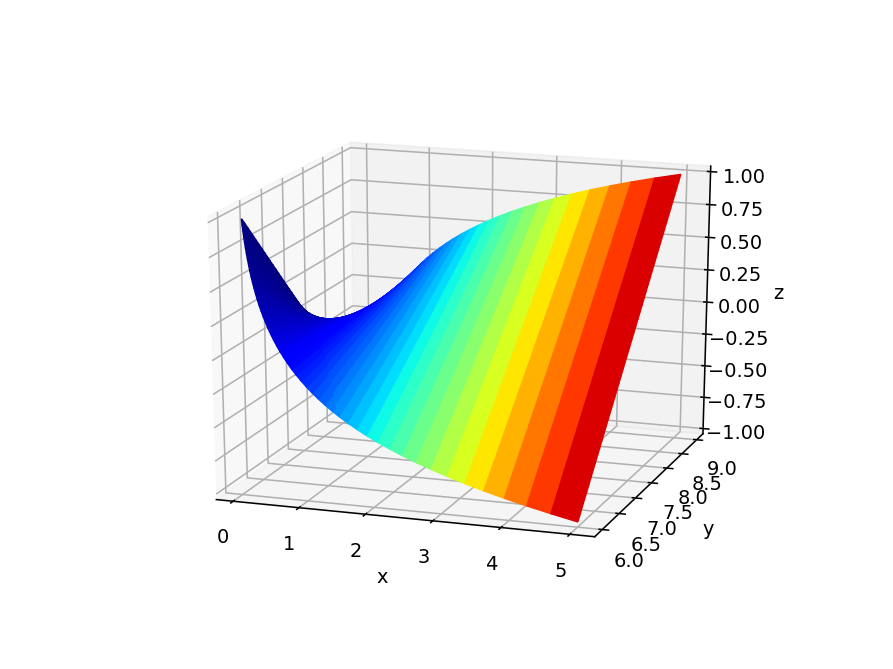

In [45]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# domains
x = np.logspace(-1.,np.log10(5),50) # [0.1, 5]
y = np.linspace(6,9,50)             # [6, 9]
z = np.linspace(-1,1,50)            # [-1, 1]

# convert to 2d matrices
Z = np.outer(z.T, z)        # 50x50
X, Y = np.meshgrid(x, y)    # 50x50

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = X # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = mpl.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.canvas.show()

In [36]:
#Ｆｏｒ　３０　ｄｅｇ　ｓｃａｎ Ｐｌｏｔ　ｗｉｔｈ　ｔｈｅ　ｃｏｏｒｄｉｎａｔe　ｏｆ　ｄａｔａ
fpath = r'D:\5_Neutron Scattering\6_E2_April_2015\field_along110/'  
fname = r'30mK_1p25T_sub_20k.hdf'
#fname = r'30mK_0p25T_one30_sub_20k.hdf'

x, y, z, data  = loadE2(fpath,fname)
xyzLens, xyzBins = [500,500,10], [5,5,2]
x1, y1, z1, data_view = binningE2(x, y, z, data, xyzLens, xyzBins)

#　make grid
x, y, z = np.meshgrid(x1,y1,z1, indexing='ij')  
print(np.shape(x),np.shape(y),np.shape(z))
#x.tofile('D:/5_Neutron Scattering/6_E2_April_2015/output.txt', sep = ' ')

#use iso_surface
%gui qt
mlab.figure(bgcolor=(1,1,1), fgcolor=(0.,0.,0.))
grid=mlab.pipeline.scalar_field(x,y,z,data_view)
#grid.spacing=[1.0, 1.0, 2]

#mlab.pipeline.volume(grid,vmin=-0.001, vmax=0.008)
#extend: shape of the volume but the axis lable changes also. Axes range could change the lable back.
isos = mlab.pipeline.iso_surface(grid,opacity=0.5,transparent=True,
                          vmin=-0.0001,vmax=0.007,extent=[-2.6,0.7,0.4,6.,-0.15,2],
                          contours=[-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007])
#, ranges=[])

# obj = mlab.imshow(img) # not working
# isos.actor.orientation = [0, 0, 1]  # the required orientation 
# isos.actor.position = [0, 0, 0]     # the required  position 
# isos.actor.scale = [1, 1, 1]        # the required scale

mlab.outline()

ax = mlab.axes(xlabel=r"[H,H,0]",ylabel="[0,0,L]",zlabel="[K,-K,0]",
              nb_labels=5,ranges=[0.5,-2.5,0.4,6,-0.5,0.4])
#ax = m.axes(color=(1.0,1.0,1.0),nb_labels=4, xlabel='Delay (ps)', ylabel='Wavelength (nm)', x_axis_visibility=True, y_axis_visibility=True, z_axis_visibility=False, ranges=[tdelays.min(), tdelays.max(), wls.min(), wls.max(), 0, 1], figure=f)
#ax.label_text_property.font_family = 'courier'
ax.label_text_property.font_size = 100
ax.axes.font_factor = 1
ax.axes.label_format = '%1.1f'
ax.label_text_property.bold = False
ax.label_text_property.italic = False
ax.label_text_property.color = (.0, .0, .0)
ax.property.color = (1.0, 1.0, 1.0)
ax.title_text_property.bold = False
ax.title_text_property.italic = False

# cb = mlab.colorbar(orientation='vertical')
# cb.scalar_bar_representation.position = [0.1, 0.9]
# cb.scalar_bar_representation.position2 = [0.8, 0.05]

mmsclut = isos.module_manager.scalar_lut_manager
mmsclut.show_scalar_bar = True
mmsclutsc = mmsclut.scalar_bar
mmsclutsc.orientation = "vertical"    # or "horizontal"
mmsclutsc.width = 0.1
mmsclutsc.height = 0.8
mmsclutsc.position = (0.01, 0.15)     # color bar located to the left of the rendering window
mmsclutsc.label_text_property.color = (0.,0.,0.)
mmsclutsc.title_text_property.color = (0.,0.,0.)
mmsclutsc.title_text_property.font_size = 3
mmsclut.number_of_labels = 10
mmsclut.number_of_colors = 64
mmsclut.data_name = "My Label"
#try to set bounds but failed .but both out line and bound canbe set by cliking
#mlab.axes.bounds = np.array([-2.6 ,  0.7 ,  0.4 ,  6.  , -0.15,  0.4 ])


In [42]:
#use conture3d
%gui qt
mlab.contour3d(x,y,z,data_view,
               opacity=0.5,transparent=True,vmin=-0.0001,vmax=0.007,contours=[-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007])
mlab.outline()
mlab.axes()
mlab.colorbar(orientation='vertical')
#extent=(0,3,0,6,-0.5,1.5),

In [44]:
# add moveing plane
mlab.clf()
mlab.contour3d(x,y,z,data_view,
               opacity=0.5,transparent=True,vmin=-0.0001,vmax=0.007,contours=[-0.0001,0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0008,0.001,0.0012,0.0015,0.0018,0.0022,0.0023,0.0026,0.003,0.0033,0.0036,0.004,0.0045,0.005,0.0055,0.006,0.007])

mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(data_view),vmin=0, vmax=0.015,
                            plane_orientation='z_axes',
                            slice_index=10)
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(data_view),vmin=0, vmax=0.015,
                            plane_orientation='x_axes',
                            slice_index=10)
mlab.outline()

## Below are examples

In [33]:
from mayavi import mlab
import numpy as np

# my dataset -simplified-
x,y,z = np.mgrid[-3:3:100j, -3:3:100j, -3:3:100j]
values = np.sqrt(x**2 + y**2 + z **2)

# my color values : the volume is divided in 3 sub-volumes along x taking 
colorvalues=np.empty(values.shape)
colorvalues[0:33,:,:]=0.
colorvalues[33:66,:,:]=2.
colorvalues[66:,:,:]  =1.

src = mlab.pipeline.scalar_field(values)
src.image_data.point_data.add_array(colorvalues.T.ravel())
src.image_data.point_data.get_array(1).name = 'myID'
src.image_data.point_data.update()

# the surface i am interested on
contour = mlab.pipeline.contour(src)
contour.filter.contours= [2.8,]

# to map the ID
contour2 = mlab.pipeline.set_active_attribute(contour, point_scalars='myID')

# And we display the surface The colormap is the current attribute: the ID.
mySurf=mlab.pipeline.surface(contour2)

# I change my colormap to a discrete one : R-G-B 
mySurf.module_manager.scalar_lut_manager.lut.table = np.array([[255,0,0,255],[0,255,0,255],[0,0,255,255]])

mlab.colorbar(title='ID', orientation='vertical', nb_labels=3)      
mlab.show()

Exception occurred in traits notification handler for object: <mayavi.tools.filters.SetActiveAttributeFactory object at 0x0000000022A51360>, trait: point_scalars, old value: , new value: myID
Traceback (most recent call last):
  File "C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\traits\trait_notifiers.py", line 340, in __call__
    self.handler( *args )
  File "C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\mayavi\tools\pipe_base.py", line 198, in _anytrait_changed
    setattr(obj, components[-1], value)
  File "C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\mayavi\core\trait_defs.py", line 97, in set_value
    raise TraitError(object, name,"one of %s"%values, value)
TraitError: The 'point_scalars_name' trait of a SetActiveAttribute instance must be one of ['scalar', ''], but a value of 'myID' <type 'str'> was specified.


TraitError: The 'point_scalars_name' trait of a SetActiveAttribute instance must be one of ['scalar', ''], but a value of 'myID' <type 'str'> was specified.

In [ ]:
from mayavi import mlab
from tvtk.tools import visual
# Create a figure
f = mlab.figure(size=(500,500))
# Tell visual to use this as the viewer.
visual.set_viewer(f)

# A silly visualization.
mlab.test_plot3d()

# Even sillier animation.
b1 = visual.box()
b2 = visual.box(x=4., color=(0.5,0.5,0.5))
b3 = visual.box(x=-4, color=(1,0.5,0))
b1.v = 5.0

@mlab.show
@mlab.animate(delay=250)
def anim():
    """Animate the b1 box."""
    while 1:
        b1.x = b1.x + b1.v*0.1
        if b1.x > 2.5 or b1.x < -2.5:
            b1.v = -b1.v
        yield

# Run the animation.
anim()

In [ ]:
from mayavi import mlab
from tvtk.tools import visual
s = visual.sphere()
s.edit_traits() # Edit sphere actor's properties via GUI

In [ ]:
################################################################################
# Create some data
import numpy as np
pi  = np.pi
cos = np.cos
sin = np.sin

phi, theta = np.mgrid[0:pi:180j,0:2*pi:180j]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 1; m5 = 2; m6 = 2; m7 = 4;
s = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = sin(phi)*cos(theta)
y = cos(phi)
z = sin(phi)*sin(theta)

################################################################################
# Plot the data
from mayavi import mlab

# A first plot in 3D
fig = mlab.figure(1)
mlab.clf()
mesh = mlab.mesh(x, y, z, scalars=s)
cursor3d = mlab.points3d(0., 0., 0., mode='axes',
                                color=(0, 0, 0),
                                scale_factor=0.5)
mlab.title('Click on the ball')

# A second plot, flat
fig2d = mlab.figure(2)
mlab.clf()
im = mlab.imshow(s)
cursor = mlab.points3d(0, 0, 0, mode='2dthick_cross',
                                color=(0, 0, 0),
                                scale_factor=10)
mlab.view(90, 0)

################################################################################
# Some logic to select 'mesh' and the data index when picking.

def picker_callback(picker_obj):
    picked = picker_obj.actors
    if mesh.actor.actor._vtk_obj in [o._vtk_obj for o in picked]:
        # m.mlab_source.points is the points array underlying the vtk
        # dataset. GetPointId return the index in this array.
        x_, y_ = np.lib.index_tricks.unravel_index(picker_obj.point_id,
                                                                s.shape)
        print("Data indices: %i, %i" % (x_, y_))
        n_x, n_y = s.shape
        cursor.mlab_source.reset(x=x_ - n_x/2.,
                               y=y_ - n_y/2.)
        cursor3d.mlab_source.reset(x=x[x_, y_],
                                 y=y[x_, y_],
                                 z=z[x_, y_])

fig.on_mouse_pick(picker_callback)

mlab.show()

In [88]:
#One example
#mayavi:Create the spherical harmonic.
# Create the data.
%gui qt
from numpy import pi, sin, cos, mgrid
dphi, dtheta = pi/250.0, pi/250.0
[phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = r*sin(phi)*cos(theta)
y = r*cos(phi)
z = r*sin(phi)*sin(theta)

# View it.
from mayavi import mlab
s = mlab.mesh(x, y, z)
mlab.show()

In [89]:
# vkt: Create the spherical harmonic.
from numpy import pi, cos, sin, mgrid
dphi, dtheta = pi/250.0, pi/250.0
[phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
m0, m1, m2, m3, m4, m5, m6, m7 = 4, 3, 2, 3, 6, 2, 6, 4
r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = r*sin(phi)*cos(theta)
y = r*cos(phi)
z = r*sin(phi)*sin(theta)
# Now show the surface.
from tvtk.tools import mlab
fig = mlab.figure()
s =mlab.Surf(x, y, z, z)
fig.add(s)

TraitError: The 'input' trait of a PolyDataMapper instance is 'read only'.

In [86]:
#Example
####Plot multi surface of a sphear
import numpy as np
from tvtk.api import tvtk
from mayavi import mlab
points = np.random.normal(0, 1, (1000, 3))

ug = tvtk.UnstructuredGrid(points=points)
ug.point_data.scalars = np.sqrt(np.sum(points**2, axis=1))
ug.point_data.scalars.name = "value"

ds = mlab.pipeline.add_dataset(ug)

delaunay = mlab.pipeline.delaunay3d(ds)
iso = mlab.pipeline.iso_surface(delaunay)
iso.actor.property.opacity = 0.1
iso.contour.number_of_contours = 10
mlab.show()

In [41]:
#In VTK there are 3 types of "structured" grids, vtkImageData 
# (vtkUniformGrid derives from this), vtkRectilinearGrid, and 
# vtkStructuredGrid. They are all structured in 
# the sense that the topology is set. vtkImageData has 
# constant spacing between points and is axis aligned, 
# vtkRectilinearGrid is axis aligned but can vary the spacing 
# in each axis direction, and vtkStructuredGrid has arbitrarily 
# located points (cells may not be valid though).
from vtk import *
dx = 2.0
grid = vtkImageData()
grid.SetOrigin(0, 0, 0) # default values
grid.SetSpacing(dx, dx, dx)
grid.SetDimensions(5, 8, 10) # number of points in each direction
# print grid.GetNumberOfPoints()
# print grid.GetNumberOfCells()
array = vtkDoubleArray()
array.SetNumberOfComponents(1) # this is 3 for a vector
array.SetNumberOfTuples(grid.GetNumberOfPoints())
for i in range(grid.GetNumberOfPoints()):
    array.SetValue(i, 1)

grid.GetPointData().AddArray(array)
# print grid.GetPointData().GetNumberOfArrays()
array.SetName("unit array")

In [90]:
#Example
import numpy as np
from mayavi import mlab
import matplotlib.pyplot as plt
x, y, z = np.ogrid[-10:10:20j, -10:10:20j, -10:10:20j]
s = np.sin(x*y*z)/(x*y*z)

mlab.contour3d(s)

In [43]:
mlab.pipeline.volume(mlab.pipeline.scalar_field(s))

In [44]:
mlab.pipeline.volume(mlab.pipeline.scalar_field(s), vmin=0, vmax=0.8)

In [56]:
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='x_axes',
                            slice_index=10,
                        )
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='y_axes',
                            slice_index=10,
                        )
mlab.outline()

In [45]:
#Plot sphearal harmanics
from mayavi import mlab
import numpy as np
from scipy.special import sph_harm

# Create a sphere
r = 0.3
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0:pi:101j, 0:2 * pi:101j]

x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)

mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
mlab.clf()
# Represent spherical harmonics on the surface of the sphere
for n in range(1, 6):
    for m in range(n):
        s = sph_harm(m, n, theta, phi).real

        mlab.mesh(x - m, y - n, z, scalars=s, colormap='jet')

        s[s < 0] *= 0.97

        s /= s.max()
        mlab.mesh(s * x - m, s * y - n, s * z + 1.3,
                  scalars=s, colormap='Spectral')

mlab.view(90, 70, 6.2, (-1.3, -2.9, 0.25))
mlab.show()


In [46]:
#My plot sphearal harmanics
x, y, z = np.ogrid[-1:1:20j, -1:1:20j, -1:1:20j]
r=np.sqrt(x**2+y**2+z**2)
phi=np.arccos(z/r)
theta=np.arccos(x/r/np.sin(phi))
#print(phi)
#print(theta)
s = 6*sph_harm(2, 3, theta, phi).real
#print(s)
#mlab.pipeline.scalar_field(s)
mlab.contour3d(s)


In [47]:
mlab.pipeline.volume(
            mlab.pipeline.scalar_field(s,colormap="jet"))

In [67]:
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='x_axes',
                            slice_index=10,
                        )
mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='y_axes',
                            slice_index=10,
                        )
mlab.outline()

In [85]:
#Interactive application:B field from the hemholtz coil 
"""
=================
Coil Application
=================

An application to visualize the field create by a list of
coils.

This code is fairly complex, but it is actuallty a very rich application,
and a full-blown example of what you might want to do
"""

import numpy as np
from scipy import linalg, special
from traits.api import HasTraits, Array, CFloat, Str, List, \
   Instance, on_trait_change
from traitsui.api import Item, View, HGroup, ListEditor, \
        HSplit, VSplit, spring
from mayavi.core.ui.api import EngineView, MlabSceneModel, \
        SceneEditor

##############################################################################
# A current loop

class Loop(HasTraits):
    """ A current loop.
    """
    direction = Array(float, value=(0, 0, 1), cols=3,
                    shape=(3,), desc='directing vector of the loop',
                    enter_set=True, auto_set=False)

    # CFloat tries to convert automatically to floats
    radius    = CFloat(0.1, desc='radius of the loop',
                    enter_set=True, auto_set=False)

    position  = Array(float, value=(0, 0, 0), cols=3,
                    shape=(3,), desc='position of the center of the loop',
                    enter_set=True, auto_set=False)

    plot      = None

    name      = Str

    view = View(HGroup(Item('name', style='readonly', show_label=False),
                       spring, 'radius'),
                'position', 'direction', '_')

    # For a Borg-like pattern
    __shared_state = {'number':0}

    def __init__(self, **traits):
        HasTraits.__init__(self, **traits)
        self.__shared_state['number'] += 1
        self.name =  'Coil %i' % self.__shared_state['number']

    def base_vectors(self):
        """ Returns 3 orthognal base vectors, the first one colinear to
            the axis of the loop.
        """
        # normalize n
        n = self.direction / (self.direction**2).sum(axis=-1)

        # choose two vectors perpendicular to n 
        # choice is arbitrary since the coil is symetric about n
        if  np.abs(n[0])==1 :
            l = np.r_[n[2], 0, -n[0]]
        else:
            l = np.r_[0, n[2], -n[1]]

        l /= (l**2).sum(axis=-1)
        m = np.cross(n, l)
        return n, l, m

    @on_trait_change('direction,radius,position')
    def redraw(self):
        if hasattr(self, 'app'):
            self.mk_B_field()
            if self.app.scene._renderer is not None:
                self.display()
                self.app.visualize_field()

    def display(self, half=False):
        """
        Display the coil in the 3D view.
        If half is True, display only one half of the coil.
        """
        n, l, m = self.base_vectors()
        theta = np.linspace(0, (2-half)*np.pi, 30)
        theta = theta[..., np.newaxis]
        coil = self.radius*(np.sin(theta)*l + np.cos(theta)*m)
        coil += self.position
        coil_x, coil_y, coil_z = coil.T
        if self.plot is None:
            self.plot = self.app.scene.mlab.plot3d(coil_x, coil_y, coil_z, 
                                    tube_radius=0.007, color=(0, 0, 1),
                                    name=self.name )
        else:
            self.plot.mlab_source.set(x=coil_x, y=coil_y, z=coil_z)

    def mk_B_field(self):
        """
        returns the magnetic field for the current loop calculated 
        from eqns (1) and (2) in Phys Rev A Vol. 35, N 4, pp. 1535-1546; 1987. 

        return: 
            B is a vector for the B field at point r in inverse units of 
        (mu I) / (2 pi d) 
        for I in amps and d in meters and mu = 4 pi * 10^-7 we get Tesla 
        """
        ### Translate the coordinates in the coil's frame
        n, l, m = self.base_vectors()
        R       = self.radius
        r0      = self.position
        r       = np.c_[np.ravel(self.app.X), np.ravel(self.app.Y),
                                                np.ravel(self.app.Z)]

        # transformation matrix coil frame to lab frame
        trans = np.vstack((l, m, n))

        r -= r0	  #point location from center of coil
        r = np.dot(r, linalg.inv(trans) ) 	    #transform vector to coil frame 

        #### calculate field

        # express the coordinates in polar form
        x = r[:, 0]
        y = r[:, 1]
        z = r[:, 2]
        rho = np.sqrt(x**2 + y**2)
        theta = np.arctan(x/y)

        E = special.ellipe((4 * R * rho)/( (R + rho)**2 + z**2))
        K = special.ellipk((4 * R * rho)/( (R + rho)**2 + z**2))
        Bz =  1/np.sqrt((R + rho)**2 + z**2) * ( 
                    K 
                  + E * (R**2 - rho**2 - z**2)/((R - rho)**2 + z**2) 
                )
        Brho = z/(rho*np.sqrt((R + rho)**2 + z**2)) * ( 
                -K 
                + E * (R**2 + rho**2 + z**2)/((R - rho)**2 + z**2) 
                )
        # On the axis of the coil we get a divided by zero here. This returns a
        # NaN, where the field is actually zero :
        Brho[np.isnan(Brho)] = 0

        B = np.c_[np.cos(theta)*Brho, np.sin(theta)*Brho, Bz ]

        # Rotate the field back in the lab's frame
        B = np.dot(B, trans)

        Bx, By, Bz = B.T
        Bx = np.reshape(Bx, self.app.X.shape)
        By = np.reshape(By, self.app.X.shape)
        Bz = np.reshape(Bz, self.app.X.shape)

        Bnorm = np.sqrt(Bx**2 + By**2 + Bz**2)

        # We need to threshold ourselves, rather than with VTK, to be able 
        # to use an ImageData
        Bmax = 10 * np.median(Bnorm)

        Bx[Bnorm > Bmax] = np.NAN 
        By[Bnorm > Bmax] = np.NAN
        Bz[Bnorm > Bmax] = np.NAN
        Bnorm[Bnorm > Bmax] = np.NAN

        self.Bx = Bx
        self.By = By
        self.Bz = Bz
        self.Bnorm = Bnorm


##############################################################################
# The application

class Application(HasTraits):

    scene = Instance(MlabSceneModel, (), editor=SceneEditor())

    # The mayavi engine view.
    engine_view = Instance(EngineView)

    # We use a traits List to be able to add coils to it
    coils = List(Loop,
                    value=( Loop(position=(0, 0, -0.05), ),
                            Loop(position=(0, 0,  0.05), ), ),
                    editor=ListEditor(use_notebook=True, deletable=False,
                                        style='custom'),
                 )

    # The grid of points on which we want to evaluate the field
    X, Y, Z = np.mgrid[-0.15:0.15:20j, -0.15:0.15:20j, -0.15:0.15:20j]

    # Avoid rounding issues:
    f = 1e4  # this gives the precision we are interested by :
    X = np.round(X * f) / f
    Y = np.round(Y * f) / f
    Z = np.round(Z * f) / f

    Bx    = Array(value=np.zeros_like(X))
    By    = Array(value=np.zeros_like(X))
    Bz    = Array(value=np.zeros_like(X))
    Bnorm = Array(value=np.zeros_like(X))

    field = None

    def __init__(self, **traits):
        HasTraits.__init__(self, **traits)
        self.engine_view = EngineView(engine=self.scene.engine)

    @on_trait_change('scene.activated')
    def init_view(self):
        # This gets fired when the viewer of the scene is created
        self.scene.scene_editor.background = (0, 0, 0)
        for coil in self.coils:
            coil.app = self
            coil.display()
            coil.mk_B_field()

        self.visualize_field()

    def visualize_field(self):
        self.Bx    = np.zeros_like(self.X)
        self.By    = np.zeros_like(self.X)
        self.Bz    = np.zeros_like(self.X)
        self.Bnorm = np.zeros_like(self.X)
        for coil in self.coils:
            if hasattr(coil, 'Bx'):
                self.Bx += coil.Bx
                self.By += coil.By
                self.Bz += coil.Bz
                self.Bnorm += coil.Bnorm

        if self.field is None:
            self.field = self.scene.mlab.pipeline.vector_field(
                            self.X, self.Y, self.Z, self.Bx, self.By, self.Bz, 
                            scalars = self.Bnorm,
                            name='B field')
            vectors = self.scene.mlab.pipeline.vectors(self.field,
                                    mode='arrow', resolution=10,
                                    mask_points=6, colormap='YlOrRd',
                                    scale_factor=2*np.abs(self.X[0,0,0]
                                                          -self.X[1,1,1]) )
            vectors.module_manager.vector_lut_manager.reverse_lut = True
            vectors.glyph.mask_points.random_mode = False
            self.scene.mlab.axes()
            self.scp = self.scene.mlab.pipeline.scalar_cut_plane(self.field,
                                                      colormap='hot')
        else:
            self.field.mlab_source.set(x=self.X,  y=self.Y,  z=self.Z,
                                       u=self.Bx, v=self.By, w=self.Bz,
                                       scalars=self.Bnorm)

    view = View(HSplit(
                    VSplit(Item(name='engine_view',
                                   style='custom',
                                   resizable=True),
                            Item('coils', springy=True),
                        show_labels=False),
                        'scene',
                        show_labels=False),
                    resizable=True,
                    title='Coils...',
                    height=0.8,
                    width=0.8,
                )

##############################################################################
if __name__ == '__main__':
    app = Application()
    app.configure_traits()



In [48]:
"""
Adjust cropping extents example
http://docs.enthought.com/mayavi/mayavi/auto/example_adjust_cropping_extents.html
# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>
# Copyright (c) 2010, Enthought, Inc.
# License: BSD Style.
"""

################################################################################
# Create a set of points, with given density
import numpy as np
x, y, z, s = np.random.random((4, 500))

################################################################################
# A dialog to edit a range interactively and propagate it to the filter
from traits.api import HasTraits, Range, Float, Instance, \
    on_trait_change
from traitsui.api import View

class ExtentDialog(HasTraits):
    """ A dialog to graphical adjust the extents of a filter.
    """

    # Data extents
    data_x_min = Float
    data_x_max = Float
    data_y_min = Float
    data_y_max = Float
    data_z_min = Float
    data_z_max = Float

    x_min = Range('data_x_min', 'data_x_max', 'data_x_min')
    x_max = Range('data_x_min', 'data_x_max', 'data_x_max')
    y_min = Range('data_y_min', 'data_y_max', 'data_y_min')
    y_max = Range('data_y_min', 'data_y_max', 'data_y_max')
    z_min = Range('data_z_min', 'data_z_max', 'data_z_min')
    z_max = Range('data_z_min', 'data_z_max', 'data_z_max')

    filter = Instance(HasTraits, allow_none=False)

    @on_trait_change('x_min,x_max,y_min,y_max,z_min,z_max')
    def update_extent(self):
        if (self.filter is not None
                    and self.x_min < self.x_max
                    and self.y_min < self.y_max
                    and self.z_min < self.z_max
                            ):
            self.filter.extent = (self.x_min, self.x_max,
                                  self.y_min, self.y_max,
                                  self.z_min, self.z_max)

    view = View('x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max',
                title='Edit extent', resizable=True)


################################################################################
# Now build the visualization using mlab
from mayavi import mlab
fig = mlab.figure(1, bgcolor=(1, 1, 1))

# Create unconnected points
pts = mlab.pipeline.scalar_scatter(x, y, z, s)
mlab.outline(pts)

# Use a geometry_filter to filter with a bounding box
geometry_filter = mlab.pipeline.user_defined(pts,
                                   filter='GeometryFilter')
geometry_filter.filter.extent_clipping = True
# Connect our dialog to the filter
extent_dialog = ExtentDialog(
            data_x_min=0, data_x_max=1,
            data_y_min=0, data_y_max=1,
            data_z_min=0, data_z_max=1,
            filter=geometry_filter.filter)
# We need to use 'edit_traits' and not 'configure_traits()' as we do
# not want to start the GUI event loop (the call to mlab.show())
# at the end of the script will do it.
extent_dialog.edit_traits()

# The geometry_filter leaves hanging points, we need to add a
# CleanPolyData filter to get rid of these.
clip = mlab.pipeline.user_defined(geometry_filter,
                                    filter='CleanPolyData')

# Finally, visualize the remaining points with spheres using a glyph
# module
spheres = mlab.pipeline.glyph(clip, scale_factor=.1)

mlab.show()

In [55]:
#　Ｍａｎｉｐｕｌａｔｅ　ｔｈｅ　ｐｌｏｔ
from numpy import arange, pi, cos, sin

from traits.api import HasTraits, Range, Instance, \
        on_trait_change
from traitsui.api import View, Item, Group

from mayavi.core.api import PipelineBase
from mayavi.core.ui.api import MayaviScene, SceneEditor, \
                MlabSceneModel


dphi = pi/1000.
phi = arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')

def curve(n_mer, n_long):
    mu = phi*n_mer
    x = cos(mu) * (1 + cos(n_long * mu/n_mer)*0.5)
    y = sin(mu) * (1 + cos(n_long * mu/n_mer)*0.5)
    z = 0.5 * sin(n_long*mu/n_mer)
    t = sin(mu)
    return x, y, z, t


class MyModel(HasTraits):
    n_meridional    = Range(0, 30, 6, )#mode='spinner')
    n_longitudinal  = Range(0, 30, 11, )#mode='spinner')

    scene = Instance(MlabSceneModel, ())

    plot = Instance(PipelineBase)


    # When the scene is activated, or when the parameters are changed, we
    # update the plot.
    @on_trait_change('n_meridional,n_longitudinal,scene.activated')
    def update_plot(self):
        x, y, z, t = curve(self.n_meridional, self.n_longitudinal)
        if self.plot is None:
            self.plot = self.scene.mlab.plot3d(x, y, z, t,
                                tube_radius=0.025, colormap='Spectral')
        else:
            self.plot.mlab_source.set(x=x, y=y, z=z, scalars=t)


    # The layout of the dialog created
    view = View(Item('scene', editor=SceneEditor(scene_class=MayaviScene),
                     height=250, width=300, show_label=False),
                Group(
                        '_', 'n_meridional', 'n_longitudinal',
                     ),
                resizable=True,
                )

my_model = MyModel()
my_model.configure_traits()

False

In [56]:
# Manipulate
import numpy as np
import scipy

from traits.api import HasTraits, Range, Instance, \
        on_trait_change, Array, Tuple, Str
from traitsui.api import View, Item, HSplit, Group

from mayavi import mlab
from mayavi.core.ui.api import MayaviScene, MlabSceneModel, \
    SceneEditor

################################################################################
# `Lorenz` class.
################################################################################
class Lorenz(HasTraits):

    # The parameters for the Lorenz system, defaults to the standard ones.
    s = Range(0.0, 20.0, 10.0, desc='the parameter s', enter_set=True,
              auto_set=False)
    r = Range(0.0, 50.0, 28.0, desc='the parameter r', enter_set=True,
              auto_set=False)
    b = Range(0.0, 10.0, 8./3., desc='the parameter b', enter_set=True,
              auto_set=False)

    # These expressions are evaluated to compute the right hand sides of
    # the ODE.  Defaults to the Lorenz system.
    u = Str('s*(y-x)', desc='the x component of the velocity',
            auto_set=False, enter_set=True)
    v = Str('r*x - y - x*z', desc='the y component of the velocity',
            auto_set=False, enter_set=True)
    w = Str('x*y - b*z', desc='the z component of the velocity',
            auto_set=False, enter_set=True)

    # Tuple of x, y, z arrays where the field is sampled.
    points = Tuple(Array, Array, Array)

    # The mayavi(mlab) scene.
    scene = Instance(MlabSceneModel, args=())

    # The "flow" which is a Mayavi streamline module.
    flow = Instance(HasTraits)

    ########################################
    # The UI view to show the user.
    view = View(HSplit(
                    Group(
                        Item('scene', editor=SceneEditor(scene_class=MayaviScene),
                             height=500, width=500, show_label=False)),
                    Group(
                        Item('s'),
                        Item('r'),
                        Item('b'),
                        Item('u'), Item('v'), Item('w')),
                    ),
                resizable=True
                )

    ######################################################################
    # Trait handlers.
    ######################################################################

    # Note that in the `on_trait_change` call below we listen for the
    # `scene.activated` trait.  This conveniently ensures that the flow
    # is generated as soon as the mlab `scene` is activated (which
    # happens when the configure/edit_traits method is called).  This
    # eliminates the need to manually call the `update_flow` method etc.
    @on_trait_change('s, r, b, scene.activated')
    def update_flow(self):
        x, y, z = self.points
        u, v, w = self.get_uvw()
        self.flow.mlab_source.set(u=u, v=v, w=w)

    @on_trait_change('u')
    def update_u(self):
        self.flow.mlab_source.set(u=self.get_vel('u'))

    @on_trait_change('v')
    def update_v(self):
        self.flow.mlab_source.set(v=self.get_vel('v'))

    @on_trait_change('w')
    def update_w(self):
        self.flow.mlab_source.set(w=self.get_vel('w'))

    def get_uvw(self):
        return self.get_vel('u'), self.get_vel('v'), self.get_vel('w')

    def get_vel(self, comp):
        """This function basically evaluates the user specified system
        of equations using scipy.
        """
        func_str = getattr(self, comp)
        try:
            g = scipy.__dict__
            x, y, z = self.points
            s, r, b = self.s, self.r, self.b
            val = eval(func_str, g,
                        {'x': x, 'y': y, 'z': z,
                         's':s, 'r':r, 'b': b})
        except:
            # Mistake, so return the original value.
            val = getattr(self.flow.mlab_source, comp)
        return val

    ######################################################################
    # Private interface.
    ######################################################################
    def _points_default(self):
        x, y, z = np.mgrid[-50:50:100j,-50:50:100j,-10:60:70j]
        return x, y, z

    def _flow_default(self):
        x, y, z = self.points
        u, v, w = self.get_uvw()
        f = self.scene.mlab.flow(x, y, z, u, v, w)
        f.stream_tracer.integration_direction = 'both'
        f.stream_tracer.maximum_propagation = 200
        src = f.mlab_source.m_data
        o = mlab.outline()
        mlab.view(120, 60, 150)
        return f


if __name__ == '__main__':
    # Instantiate the class and configure its traits.
    lor = Lorenz()
    lor.configure_traits()